Re-attempting to get k-rho retreival for Raven SIMBA. Instead of limiting to only timesteps when there's no incoming SW, instead limit profile height to 30cm below suspected surface.

Some more info on near SIMBA thermistor locations:

at install thermistor #100 and #180(2?) were at the surface; #150 was off the upper support wood, as in it's the top of the profile into the snow; #80 and #160 were at the same height in the air

HOWEVER, the next day there was local drifting and thermistor #175 was at the surface!

Flux plate @ thermistor #190 (flux plate C?), 1cm below #200 (flux plate B?)

at demob, thermistor #209 was just above the ice chunk, about (187-59)cm below the surface. Ice chunk was ~ 20cm below middle flux plate


#### NEW combined/corrected thermistor data from Michael:

Attempt to 'reference' coordinates w.r.t. the surface, i.e. a 'height' in each bottom/middle/top dataset is the same point in space. 
Take data from 'bottom' string and put into new dataset from -300,+58 cm
Take data from 'top' string and add the temperature difference between the top/bottom thermistor string at 58cm to the entire top string at each time step. Save this into new data as 'temperature_correction' time series.
Add that corrected data to the new dataset from 'above' 58cm 

The offset I used for the bottom is +358 cm to get from old coordinates to new. For the top is +200    


In [2]:
import matplotlib.pyplot as plt
import datetime, time, math, cmocean, csv
import numpy as np
import netCDF4 as nc
from scipy import interpolate, stats
from matplotlib import rcParams
# from astropy.convolution import convolve, convolve_fft
from scipy import interpolate
from scipy.sparse import diags
import glob
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import pandas as pd
from matplotlib.colors import Normalize

### Functions

In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""
    from netCDF4 import Dataset

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()
    #print(out_vars.keys())
    return out_vars

In [4]:
def calc_profiles(temps, secs, depths, depth_idx, time_idx, rho_0, ktop=6, dz=0.02, bc_flx=False, dt=1, mask_dT=False, its=2):

    """ 
    Modified for Raven to remove any k-rho relationships that are for ice/use salinity
    
    bc_flx: lower boundary condition is flux instead of thermal conductivity"""

    rho_1 = rho_0[depth_idx[0]]

    short_depth = depths[depth_idx[0]]

    # set up off/diagonal elements
    T_k = temps[time_idx,depth_idx[0]]
    T_k1 = temps[time_idx+dt,depth_idx[0]]
    dt = secs[time_idx+dt]-secs[time_idx] # just a scalar, same for whole column


    # first attempt based on Lipscomb (1998)
    a = T_k1[:-1] - T_k1[1:]
    b = T_k1[2:] - T_k1[1:-1]
    dT = T_k1 - T_k
    # print('testing the assumption that dT=0!')
    if mask_dT:
        dT[np.where(np.abs(dT)<=0.0625)[0]] = 0

    ## masking dT<=|0.0625|
    # dT[np.where(np.abs(dT<=0.0625))[0]] = 0
    
    # from Paterson 1994
    c_t = 152.5+7.122*T_k1

    bad_top_count = 0

    ## was interated 5 times for sea ice, not sure why it's only 2 now
    ## no longer allowing the upper boundary to be lowered?
    for i in range(its):

        if i==0:
            rho_n = rho_1[:-1]
        elif type(K)==bool:
            rho_n = rho_1[:-1]
        else:
            rho_n = np.array([rho_from_k(k, T_k1[vidx]) \
                            for vidx, k in np.ndenumerate(np.squeeze(K))],
                            dtype=np.float32)

        # HERE is where boundary condition needs to be changed!
        if bc_flx:
            dend = bc_flx*dz
        else:
            # was 2 for sea ice, now 0.3 for snow?
            dend = 0.3*(temps[time_idx+1,depth_idx[0][-1]+1]\
                    -temps[time_idx+1,depth_idx[0][-1]])

        K, d, A, det_0_num = iterate_solution(dT, rho_n, c_t, dend, a, b, dt)

        # work on this
        bad_snowtop = np.where((np.squeeze(K)>=.6)&(short_depth[:-1]>ktop)) #OG

        S = d/dz # this negates dz d is multiplied by to solve for k

    # save conduction and its divergence
    # print(np.shape(np.squeeze(K)[1:]), np.shape(T_k1[2:]), np.shape(T_k1[1:-1]))
    # print(A.shape, K.shape, a.shape, b.shape, T_k1.shape, rho_n.shape)
    # this is conserved
    if type(K)==bool:
        Fc_div = False
        Fc = False
    else:
        # print(np.shape(np.squeeze(K)), np.shape(T_k1))
        # print(np.shape(np.squeeze(K)[1:]), np.shape(np.squeeze(K)[0:-1]), np.shape(T_k1[2:]), np.shape(T_k1[:-2]))
        # Fc_div =  np.squeeze(K)[:-1]*(T_k1[2:]-T_k1[1:-1]) - (np.squeeze(K)[1:]*(T_k1[1:-1]-T_k1[:-2]))
        # Fc_div /= dz**2
        Fc_div = A.dot(K)/dz

        Fc = -np.squeeze(K)*a/dz
        # alt_div = np.squeeze(K)/dz
        # print(Fc)

    return K, rho_n, S, Fc_div, Fc, bad_top_count, det_0_num

In [418]:
def calc_profiles_solar(temps, secs, depths, depth_idx, time_idx, rho_0, sw_div, ktop=6, dz=0.02, bc_flx=False, its=5):

    """ salin in input variable is Salinity, S in output is storage 
    Modified for Raven to remove any k-rho relationships that are for ice/use salinity"""

    rho_1 = rho_0[depth_idx[0]]

    # poor programming! this should be an input variable!
    short_depth = depths[depth_idx[0]]

    # set up off/diagonal elements
    T_k = temps[time_idx,depth_idx[0]]
    T_k1 = temps[time_idx+1,depth_idx[0]]
    dt = secs[time_idx+1]-secs[time_idx] # just a scalar, same for whole column
    # sw_div = sw_div_i[time_idx,depth_idx[0]]

    # first attempt based on Lipscomb (1998)
    a = T_k1[:-1] - T_k1[1:]
    b = T_k1[2:] - T_k1[1:-1]
    dT = T_k1 - T_k

    # from Paterson 1994
    c_t = 152.5+7.122*T_k1

    bad_top_count = 0

    for i in range(its):

        if i==0:
            rho_n = rho_1[:-1]
        elif type(K)==bool:
            rho_n = rho_1[:-1]

        else:
            rho_n = np.array([rho_from_k(k, T_k1[vidx]) \
                            for vidx, k in np.ndenumerate(np.squeeze(K))],
                            dtype=np.float32)

        # HERE is where boundary condition needs to be changed!
        if bc_flx:
            dend = bc_flx*dz
        else:
            # was 2 for sea ice, now 0.3 for snow?
            dend = 0.3*(temps[time_idx+1,depth_idx[0][-1]+1]\
                    -temps[time_idx+1,depth_idx[0][-1]])

        K, d, A, det_0_num = iterate_solution_solar(dT, rho_n, c_t, dend, a, b, dt, sw_div)

        # work on this
        bad_snowtop = np.where((np.squeeze(K)>=.6)&(short_depth[:-1]>ktop)) #OG


        S = d/dz # this negates dz d is multiplied by to solve for k

    # save conduction and its divergence
    # print(np.shape(np.squeeze(K)[1:]), np.shape(T_k1[2:]), np.shape(T_k1[1:-1]))
    # print(A.shape, K.shape, a.shape, b.shape, T_k1.shape, rho_n.shape)
    # this is conserved
    if type(K)==bool:
        Fc_div = False
        Fc = False
    else:
        # print(np.shape(np.squeeze(K)), np.shape(T_k1))
        # print(np.shape(np.squeeze(K)[1:]), np.shape(np.squeeze(K)[0:-1]), np.shape(T_k1[2:]), np.shape(T_k1[:-2]))
        # Fc_div =  np.squeeze(K)[:-1]*(T_k1[2:]-T_k1[1:-1]) - (np.squeeze(K)[1:]*(T_k1[1:-1]-T_k1[:-2]))
        # Fc_div /= dz**2
        Fc_div = A.dot(K)/dz

        Fc = -np.squeeze(K)*a/dz
        # alt_div = np.squeeze(K)/dz
        # print(Fc)

    return K, rho_n, S, Fc_div, Fc, bad_top_count, det_0_num

In [419]:
def iterate_solution_solar(dT_i, rho_i, c_i, d_last, a_i, b_i, dt_i, sw_div_i, dz_i=0.02):

    # separating the calculation of d in a separate function might make it more readable

    d = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i # Lipscomb

    # with solar, added 4/17/25
    d_S = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i - sw_div_i[:-1]*dz_i# Lipscomb
    
    # need some sort of boundary condition
    d_S[-1] -= d_last

    offset = [0,1]
    A = diags([a_i,b_i],offset).toarray()

    # turn into matrix with correct orientation
    d_S = np.array([d_S], dtype=np.float64).T

    # if np.linalg.det(A)!=0:
    #     K_i = np.linalg.inv(A).dot(d)
    # else:
    #     K_i = np.linalg.pinv(A).dot(d)
    #
    #     # K_i = False
    K_i = np.linalg.pinv(A).dot(d_S)


    if np.linalg.det(A)==0:
        det_0 = 1
    else:
        det_0 = 0


    return K_i, d, A, det_0

In [5]:
def iterate_solution(dT_i, rho_i, c_i, d_last, a_i, b_i, dt_i, dz_i=0.02):

    # separating the calculation of d in a separate function might make it more readable

    d = dT_i[:-1]*c_i[:-1]*rho_i*dz_i**2/dt_i # Lipscomb

    # need some sort of boundary condition
    d[-1] -= d_last

    offset = [0,1]
    A = diags([a_i,b_i],offset).toarray()

    # turn into matrix with correct orientation
    d = np.array([d], dtype=np.float64).T

    # inverting equations to solve for k
    K_i = np.linalg.pinv(A).dot(d)

    # sometimes there isn't a solution because the determinate if 0
    if np.linalg.det(A)==0:
        det_0 = 1
    else:
        det_0 = 0


    return K_i, d, A, det_0

In [6]:
def rho_from_k(k, T):

    rhos, ks = calc_k_approx(T)
    #print('in rho_from_k ks, rhos, k shapes:', np.shape(ks), np.shape(rhos), np.shape(k))

    if np.ma.masked_invalid(ks).count()==0:
        return 0

    rhos = np.squeeze(rhos)
    ks = np.squeeze(ks)
    # print(ks, k)

    f = interpolate.interp1d(ks, rhos)
    
    if k>ks.max():
        k = ks.max()
    elif k<ks.min():
        k = ks.min()

    rho_out = f(k)

    return rho_out

In [7]:
def calc_k_approx(T, rho_vals=np.linspace(50,1000,96)):

    """ calculate k values based on eq5 from calonne 2019
        T is in Kelvin"""

    # rhos = []
    # ks = []

    # constants for calculation
    a = 0.02 # m3/kg
    k_ref_i = 2.107 # W/m/K
    k_ref_a = 0.024 # W/m/K

    # # just use simple values for now, will want them to be functions of T later
    # # current values for T=-3C
    k_i = 9.828*np.exp(-5.7*10.**(-3)*T)
    k_a = 0.024 # get the rest of the linear approx of T - I guess I decided this was a small impact?

    theta = 1./(1.+np.exp(-2.*a*(rho_vals-450.)))
    k_ref_firn = 2.107 + 0.003618*(rho_vals-917.)
    k_ref_snow = 0.024 - (1.23*10**(-4))*rho_vals + (2.5*10**(-6))*(rho_vals**2)

    ks = (1. - theta)*(k_i*k_a/(k_ref_i*k_ref_a))*k_ref_snow \
            + theta*(k_i/k_ref_i)*k_ref_firn

    return rho_vals, ks

In [477]:
def calc_sw_abs_single(sw_sfc, kappa, depths_in, f_nir=0.5, dpth_st=0.):
    """ for profile of sw absorbed/extinction at one time step!
    swc_sfc is net SW from the atmosphere (SWD-SWU) 
    kappa is snow extinction coefficient, which is going to be used as a tuning parameter
    f_nir is the fraction of SW that is assumed to be NIR (as opposed to visible)
    depths is assumed to be centimeters below the surface with intervals of 2cm, i.e., 2, 4, 6 etc 
    should depths start at 0 or 2? """

    ## so that absorbed SW, clacluated as the difference between levels, covers the temperature
    # depths_in += .01

    depths = dpth_st-depths_in
    # print(depths)

    ## transmitted SW at each level
    sw_t = f_nir*sw_sfc*np.ma.exp(-kappa*depths)

    ## absorbed SW at each level
    # indexing will need to change to use SWN timeseries
    sw_a_lower = sw_t[:-1] - sw_t[1:]


    ## I think this will only work if depths_in is negative downwards
    sfc_sw_a = [sw_sfc-sw_t[0]]
    
    # sw_a = np.ma.copy(sw_a_lower)
    # sw_a[np.where(depths_in==0)] = sfc_sw_a
    
    sw_a = np.ma.concatenate((sfc_sw_a, sw_a_lower), axis=0) ## this is wrong because of 2D array with values above surface
    # sw_a = np.ma.masked_array(sw_a, mask=sw_t.mask)
    
    return sw_a, sw_t

In [8]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [9]:
def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

### Begin loading data

First from SLEIGH, the SIMBA.

Maybe later: load corrected skin temperature and fluxes

In [422]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )


asfs_data_lev2['net_short_hemisp'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']


/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

In [423]:
## corrected skin temperature
# same time steps as asfs_data_lev2['dates']
with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    sleigh_tskin_all = np.ma.MaskedArray(**npz)

In [424]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
fn = 'firnprofile_maxheight_solar-correction_created_20250417.nc'
# fn = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data = {}
if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    varnames = ['temperature','initial_height','time']
    fdic = load_netcdf(simba_filepath+fn, varnames)
else:
    varnames = ['temp','initial_height','time']
    fdic = load_netcdf(fn, varnames)

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])
else:    
    fdic['dates'] = np.asarray([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(s)) for s in fdic['time']])
season_data['seconds'] = fdic['time']

for var in ['temperature','dates','initial_height']:
    if var=='temperature' and fn=='firnprofile_maxheight_solar-correction_created_20250417.nc':
        season_data['temperature'] = fdic['temp']
    else:
        season_data[var] = fdic[var]

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    season_data['height'] = season_data['initial_height'][::-1]
    # season_data['height'] = season_data['height']#[::-1]
    season_data['temperature'] = season_data['temperature'][:,::-1]
else:
    season_data['height'] = season_data['initial_height']
# ## last thermistor was air temperature
# season_data['air_temperature'] = season_data['temperature'][:,-1]
# season_data['temperature'] = season_data['temperature'][:,:-1]
# season_data['height'] = season_data['height'][:-1]

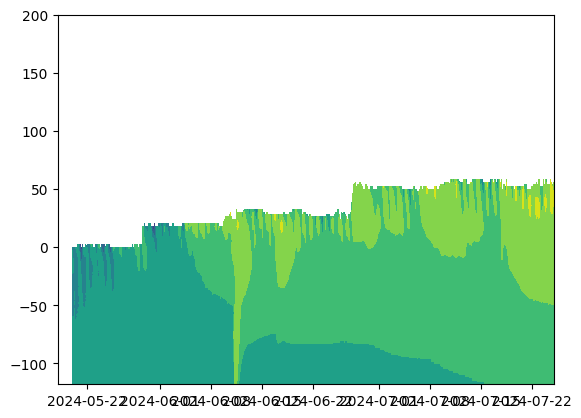

In [425]:
plt.contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1))


In [426]:
df = pd.read_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-72h-05threshold_20250416.csv')


simba_sfc_dates = np.array([datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
simba_sfc_in = df['max_index'].values
simba_sfc_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in simba_sfc_dates])

## estimate of snow-atmosphere interface made in SIMBA_sfc-id.ipynb
with np.load('/home/asledd/ICECAPS/Raven_SIMBA_sfc-id_max-T-grad_20250123.npz') as npz:
    simba_sfc = np.ma.MaskedArray(**npz)

## I know this has 15 minute time steps, so average over several hours
kernel_avg_hrs= [1./(4*6+1)]*(4*6+1)

simba_sfc = convolve(simba_sfc, kernel_avg_hrs, boundary='extend')

## try opening all SIMBA files
# turn into function later?
simba_filepath = '/psd3data/arctic/raven/simba/level1/'

lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## get rid of march files, will also probably want to get rid of first few days of actual data after install as well?
lev1_files = lev1_files[5:] ## michael deleted march files

varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = datetime.datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
    print(season_data['dates'].shape, season_data['height'].shape, season_data['temperature'].shape)

### Attempting retrieval...

In [427]:
temp_kelv = season_data['temperature']+273.15
imb_depth = season_data['height']
imb_depth_m = imb_depth/100.

# how best to limit depths?
# sfc_height = -330/100. # around 6/1/2024
# bottom_height = -400/100. ## flux plate B? which is lowest level that can be used for flux above ice chunk

sfc_height = -30./100.
bottom_height = (-400+358)/100.

imb_secs = np.array([(t-datetime.datetime(1970,1,1)).total_seconds() for _,t in np.ndenumerate(season_data['dates'])])

In [428]:
## limit time steps?
st_date = datetime.datetime(2024,5,20,)
en_date = datetime.datetime(2024,7,26,)

date_idx_asfs = np.where((asfs_data_lev2['dates']>st_date)&(asfs_data_lev2['dates']<en_date) )[0]
date_idx_imb = np.where((season_data['dates']>st_date)&(season_data['dates']<en_date) )[0]

Need to interpolate flux plates from SLEIGH time steps to match SIMBA

In [429]:
sleigh_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in asfs_data_lev2['dates']])
simba_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in season_data['dates']])

# set assume_sorted to have scipy automatically sort for you

interpolated_fp = {}
flux_plates = ['subsurface_heat_flux_A','subsurface_heat_flux_B','subsurface_heat_flux_C', 'net_short_hemisp']

for fp in flux_plates:
    fp_data = asfs_data_lev2[fp]
    f_0 = interpolate.interp1d(sleigh_seconds[~fp_data.mask], fp_data[~fp_data.mask], fill_value=-999, bounds_error=False)
    interpolated_fp[fp] = np.ma.masked_equal(f_0(simba_seconds), -999)

In [430]:
f_simba_sfc = interpolate.interp1d(simba_sfc_seconds, simba_sfc_in, fill_value=-999, bounds_error=False)

simba_sfc = f_simba_sfc(imb_secs)
simba_sfc = np.ma.masked_equal(simba_sfc, -999)

In [431]:
## for plotting and comparing
dTdt = (season_data['temperature'][1:,:] - season_data['temperature'][:-1,:])#/(15.*60) # timesteps are 15 minutes
dTdz = (season_data['temperature'][:,1:] - season_data['temperature'][:,:-1])#/0.02 # vertical resolution is 2 cm

### Loading in old temp data to see what's up...

In [367]:
## try opening all SIMBA files
# turn into function later?
simba_filepath = '/psd3data/arctic/raven/simba/level1/'

lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## get rid of march files, will also probably want to get rid of first few days of actual data after install as well?
lev1_files = lev1_files[5:] ## michael deleted march files

varnames = ['temperature','height','time']

lev1_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = datetime.datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in lev1_data:
            lev1_data[var] = fdic[var]
        else:
            lev1_data[var] = np.ma.concatenate( (lev1_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in lev1_data:
        lev1_data['height'] = fdic['height']
    print(lev1_data['dates'].shape, lev1_data['height'].shape, lev1_data['temperature'].shape)

lev1_data['air_temperature'] = lev1_data['temperature'][:,-1]
lev1_data['temperature'] = lev1_data['temperature'][:,:-1]
lev1_data['height'] = lev1_data['height'][:-1]

(96,) (241,) (96, 241)
(192,) (241,) (192, 241)
(288,) (241,) (288, 241)
(384,) (241,) (384, 241)
(480,) (241,) (480, 241)
(576,) (241,) (576, 241)
(672,) (241,) (672, 241)
(768,) (241,) (768, 241)
(864,) (241,) (864, 241)
(960,) (241,) (960, 241)
(1056,) (241,) (1056, 241)
(1152,) (241,) (1152, 241)
(1248,) (241,) (1248, 241)
(1344,) (241,) (1344, 241)
(1440,) (241,) (1440, 241)
(1536,) (241,) (1536, 241)
(1632,) (241,) (1632, 241)
(1728,) (241,) (1728, 241)
(1824,) (241,) (1824, 241)
(1920,) (241,) (1920, 241)
(2016,) (241,) (2016, 241)
(2112,) (241,) (2112, 241)
(2208,) (241,) (2208, 241)
(2304,) (241,) (2304, 241)
(2400,) (241,) (2400, 241)
(2496,) (241,) (2496, 241)
(2592,) (241,) (2592, 241)
(2688,) (241,) (2688, 241)
(2784,) (241,) (2784, 241)
(2880,) (241,) (2880, 241)
(2976,) (241,) (2976, 241)
(3072,) (241,) (3072, 241)
(3168,) (241,) (3168, 241)
(3264,) (241,) (3264, 241)
(3360,) (241,) (3360, 241)
(3456,) (241,) (3456, 241)
(3552,) (241,) (3552, 241)
(3648,) (241,) (3648, 2

In [368]:
print(lev1_data['temperature'].shape, season_data['temperature'].shape)

(9504, 240) (6527, 160)


In [369]:
lev1_data['new_height'] = lev1_data['height']+358

In [313]:
lev1_idx = np.where( (lev1_data['dates']>=datetime.datetime(2024,6,1))&(lev1_data['dates']<datetime.datetime(2024,6,15)) )
lev1_heght_idx = np.where( (lev1_data['new_height']>=-118)&(lev1_data['new_height']<=58) )
# lev1_data['dates'] = lev1_data['dates'][lev1_idx]
# lev1_data['temperature'] = lev1_data['temperature'][lev1_idx[0],:]

In [314]:
print(lev1_data['new_height'][0], lev1_data['new_height'][-1])

358 -120


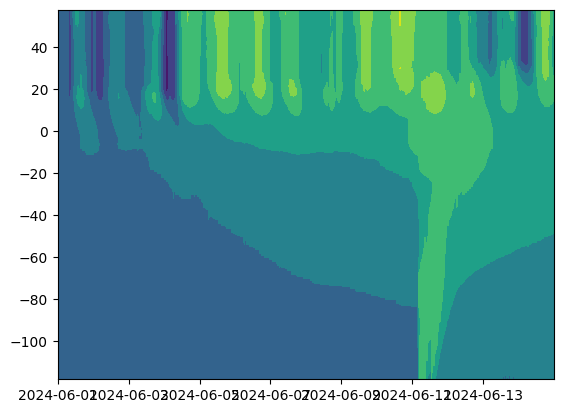

In [315]:
plt.contourf(lev1_data['dates'][lev1_idx], lev1_data['new_height'][lev1_heght_idx], np.swapaxes(lev1_data['temperature'][lev1_idx[0],:][:,lev1_heght_idx[0]],0,1))


In [316]:
season_idx = np.where( (season_data['dates']>=datetime.datetime(2024,6,1))&(season_data['dates']<datetime.datetime(2024,6,15)) )
season_height_idx = np.where( (season_data['height']>=-118)&(season_data['height']<=58) )

In [317]:
print(season_data['height'][0], season_data['height'][-1])

200 -118


In [318]:
lev1_temp_subset = lev1_data['temperature'][lev1_idx[0],:][:,lev1_heght_idx[0]]
combined_subset = season_data['temperature'][season_idx[0],:][:,season_height_idx[0]]

In [340]:
print(lev1_data['new_height'][lev1_heght_idx])
print()
print(season_data['height'][season_height_idx])

[  58   56   54   52   50   48   46   44   42   40   38   36   34   32
   30   28   26   24   22   20   18   16   14   12   10    8    6    4
    2    0   -2   -4   -6   -8  -10  -12  -14  -16  -18  -20  -22  -24
  -26  -28  -30  -32  -34  -36  -38  -40  -42  -44  -46  -48  -50  -52
  -54  -56  -58  -60  -62  -64  -66  -68  -70  -72  -74  -76  -78  -80
  -82  -84  -86  -88  -90  -92  -94  -96  -98 -100 -102 -104 -106 -108
 -110 -112 -114 -116 -118]

[  58.   56.   54.   52.   50.   48.   46.   44.   42.   40.   38.   36.
   34.   32.   30.   28.   26.   24.   22.   20.   18.   16.   14.   12.
   10.    8.    6.    4.    2.    0.   -2.   -4.   -6.   -8.  -10.  -12.
  -14.  -16.  -18.  -20.  -22.  -24.  -26.  -28.  -30.  -32.  -34.  -36.
  -38.  -40.  -42.  -44.  -46.  -48.  -50.  -52.  -54.  -56.  -58.  -60.
  -62.  -64.  -66.  -68.  -70.  -72.  -74.  -76.  -78.  -80.  -82.  -84.
  -86.  -88.  -90.  -92.  -94.  -96.  -98. -100. -102. -104. -106. -108.
 -110. -112. -114. -116. -118.]


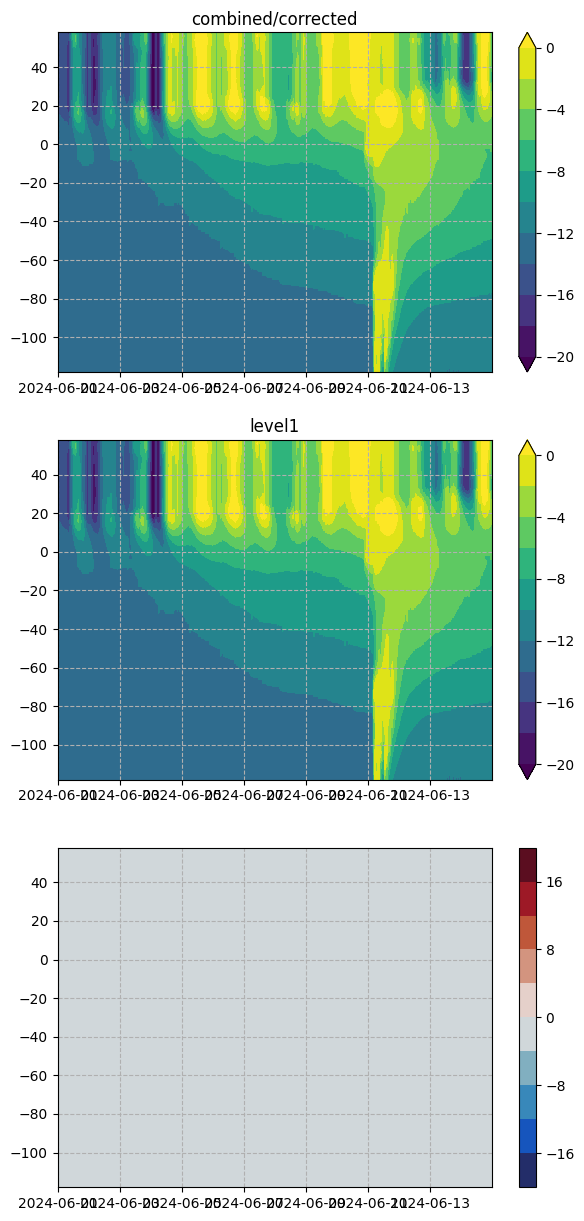

In [320]:
fig, axs = plt.subplots(3, figsize=(7,15))
cb = axs[0].contourf(season_data['dates'][season_idx], season_data['height'][season_height_idx], 
                     np.swapaxes(combined_subset,0,1), levels=np.linspace(-20,0,11), extend='both')
plt.colorbar(cb, ax=axs[0])
axs[0].set_title('combined/corrected')

cb = axs[1].contourf(lev1_data['dates'][lev1_idx], lev1_data['new_height'][lev1_heght_idx], 
                     np.swapaxes(lev1_temp_subset,0,1), levels=np.linspace(-20,0,11), extend='both')
plt.colorbar(cb, ax=axs[1])
axs[1].set_title('level1')

for ax in axs.ravel():
    # ax.axhline(y=0, c='k', ls='--')
    ax.grid(ls='--')
    
temp_diff = combined_subset - lev1_temp_subset

cb = axs[2].contourf(season_data['dates'][season_idx], season_data['height'][season_height_idx[0]], 
                     np.swapaxes(temp_diff,0,1), cmap=cmocean.cm.balance,
                    levels=np.linspace(-20,20,11))
plt.colorbar(cb, ax=axs[2])

# plt.ylim(-120,-100)

## Need to add padding to upper part of heights so that the arrays are all consistent sizes!

In [382]:

## rename these!
k_2d_not_smooth = []
rho_2d = []
S_2d = []
Fc_2d = []
Fc_div_2d = []

plt_times_not_smooth = []
plt_secs = []
plt_bad_timesteps = []

rnd_sfc_not_smth = []
## set "top" of profile as -280

# fig, axs = plt.subplots(1,4, figsize=(9,6), sharey=True)
# axs[0].set_ylabel('Height from top of chain [m]')
for _, t_idx in np.ndenumerate(date_idx_imb[1:]):
        # print(season_data['dates'][t_idx], interpolated_fp['subsurface_heat_flux_B'][t_idx])
    
        all_depths_K = []
        all_depths_rho = []
        all_depths_S = []
        all_depths_Fc = []
        all_depths_Fc_div = []

        sfc_level = round_up_to_even(simba_sfc[t_idx])/100.
        # sfc_level = 0.2
        rnd_sfc_not_smth.append(sfc_level)
        depth_idx = np.where((imb_depth_m<(sfc_level-.35))&(imb_depth_m>=bottom_height))
        rho = np.full(imb_depth_m.shape, 300.)
        # print(sfc_level, sfc_level-.3, depth_idx)

        try:
            K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(temp_kelv[:,:],
                                    imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, 
                                    bc_flx=-interpolated_fp['subsurface_heat_flux_B'][t_idx],
                                    mask_dT=True, its=5) # bc_flx = 'boundary condition flux', this number comes from looking at time series of flux plates in earlier version of this code. will eventually want to connect this to the actual measured flux
        except:
            exept_flag = False
            ## would ideally want to make a profile of -999 to keep the arrays all the same size
    
        # axs[0].plot(np.squeeze(temp_kelv[t_idx, depth_idx]), imb_depth_m[depth_idx], label=t_idx)#'t=0')

        # axs[1].plot(np.squeeze(dTdt[t_idx, depth_idx]), imb_depth_m[depth_idx])
        # axs[2].plot(np.squeeze(dTdz[t_idx, depth_idx]), imb_depth_m[depth_idx])
        # axs[3].plot(K, imb_depth_m[depth_idx][:-1])

        pad_top = [-999 for _ in np.where( (imb_depth_m<=imb_depth_m.max())&(imb_depth_m>=(sfc_level-.35)) )[0]]
        pad_bottom = [-999 for _ in np.where( (imb_depth_m>=imb_depth_m.min())&(imb_depth_m<=bottom_height) )[0]]

        # pad_top = np.full( int((imb_depth[0]-(sfc_level*100.))/2+1) ,-999)
        # pad_bottom = np.full(int((bottom_height*100.-imb_depth[-1])/2+1),-999)
        # print(season_data['dates'][t_idx], sfc_level, imb_depth_m.max(), len(pad_top), len(pad_bottom), len(K), len(pad_top)+len(pad_bottom)+len(K))
        print(season_data['dates'][t_idx], sfc_level, len(depth_idx[0]), len(pad_top), len(K), len(pad_top)+len(pad_bottom)+len(K))

        # print(K.shape)#, imb_depth_m[depth_idx].shape, temp_kelv[:,depth_idx].shape)
        if type(K)!=bool:
            # k_2d_not_smooth.append(np.ma.concatenate( (padding,np.squeeze(K)) ))
            plt_times_not_smooth.append(season_data['dates'][t_idx])
            # print(np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(K), pad_bottom),axis=0)), axis=0).shape )
            # print()
            k_2d_not_smooth.append( np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(K), pad_bottom),axis=0)), axis=0) )
            rho_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (rho_n, pad_bottom),axis=0)),axis=0) )
            S_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(S)[:-1], pad_bottom),axis=0)),axis=0) )
            Fc_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (Fc, pad_bottom),axis=0)),axis=0) )
            # all_depths_Fc_div.append( np.ma.concatenate( (Fc_div,padding) ))


            len_ld = len(depth_idx[0])

# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[0], depth_idx]), imb_depth_m[depth_idx], label='t=-1')
# axs[0].plot(np.squeeze(temp_kelv[date_idx_imb[2], depth_idx]), imb_depth_m[depth_idx], label='t=+1')
# axs[0].legend(loc='best')
#for ax, label in zip(axs.ravel(), ['Temp [K]', 'dT/dt', 'dT/dz','k']):
# for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]','k']):
#     ax.set_xlabel(label)
#     ax.grid(alpha=.5, ls='--')
#     ax.axhline(y=sfc_level-.3, c='k')

# # axs[-1].set_xlim(-.1,1)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
# #plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d:%H:%M')+'-'+en_date.strftime('%H:%M')+'.png', dpi=200)
# plt.show()

2024-05-20 00:30:00 0.0 6 116 5 160
2024-05-20 00:45:00 0.0 6 116 5 160
2024-05-20 01:00:00 0.0 6 116 5 160
2024-05-20 01:15:00 0.0 6 116 5 160
2024-05-20 01:30:00 0.0 6 116 5 160
2024-05-20 01:45:00 0.0 6 116 5 160
2024-05-20 02:00:00 0.0 6 116 5 160
2024-05-20 02:15:00 0.0 6 116 5 160
2024-05-20 02:30:00 0.0 6 116 5 160
2024-05-20 02:45:00 0.0 6 116 5 160
2024-05-20 03:00:00 0.0 6 116 5 160
2024-05-20 03:15:00 0.0 6 116 5 160
2024-05-20 03:30:00 0.0 6 116 5 160
2024-05-20 03:45:00 0.0 6 116 5 160
2024-05-20 04:00:00 0.0 6 116 5 160
2024-05-20 04:15:00 0.0 6 116 5 160
2024-05-20 04:30:00 0.0 6 116 5 160
2024-05-20 04:45:00 0.0 6 116 5 160
2024-05-20 05:00:00 0.0 6 116 5 160
2024-05-20 05:15:00 0.0 6 116 5 160
2024-05-20 05:30:00 0.0 6 116 5 160
2024-05-20 05:45:00 0.0 6 116 5 160
2024-05-20 06:00:00 0.0 6 116 5 160
2024-05-20 06:15:00 0.0 6 116 5 160
2024-05-20 06:30:00 0.0 6 116 5 160
2024-05-20 06:45:00 0.0 6 116 5 160
2024-05-20 07:00:00 0.0 6 116 5 160
2024-05-20 07:15:00 0.0 6 11

In [383]:
k_2d_not_smooth = np.ma.masked_equal(k_2d_not_smooth, -999)

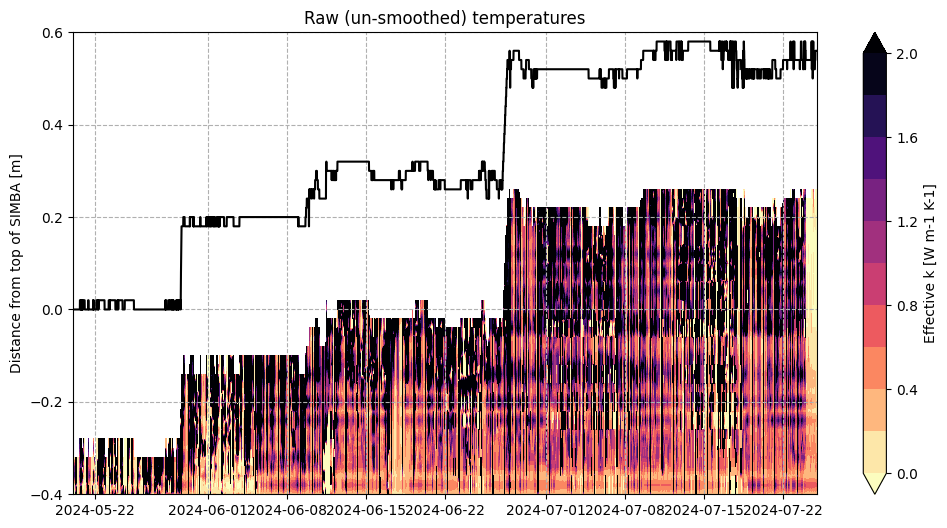

In [386]:
# padded_depth_idx = np.where((imb_depth_m<-2.8)&(imb_depth_m>=bottom_height))
fig, ax = plt.subplots(1, figsize=(12,6))
cb = ax.contourf(plt_times_not_smooth, imb_depth_m, np.swapaxes(np.ma.masked_invalid(k_2d_not_smooth),0,1),
                cmap=plt.cm.magma_r, levels=np.arange(0,2.01,.2), extend='both')
plt.colorbar(cb, label='Effective k [W m-1 K-1]')
ax.set_title('Raw (un-smoothed) temperatures')#, masking |$T_t-T_{t-1}$|<=0.0625')
ax.set_ylim(-.4, .6)

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
ax.grid(ls='--')
ax.set_ylabel('Distance from top of SIMBA [m]')

ax.plot(plt_times_not_smooth, rnd_sfc_not_smth, c='k')
ax.set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
plt.show()

Test smoothing of vertical profiles

In [387]:
# kernel_avg_10 = [1./(3)]*(3)
N = 3

smoothed_temp = []
for t in range(temp_kelv.shape[0]):

    T_kern = np.squeeze(np.copy(temp_kelv[t,:]))
    # T_smoothed = convolve(T_kern, kernel_avg_10, boundary='extend')
    T_smoothed = np.convolve(T_kern, np.ones(N)/N, mode='valid')
    T_kern = T_smoothed

    smoothed_temp.append(T_kern)

smoothed_temp = np.asarray(smoothed_temp)

## for plotting and comparing
smoothed_dTdt = (smoothed_temp[1:,:] - smoothed_temp[:-1,:])#/(15.*60) # timesteps are 15 minutes
smoothed_dTdz = (smoothed_temp[:,1:] - smoothed_temp[:,:-1])#/0.02 # vertical resolution is 2 cm


In [403]:

## rename these!
k_2d = []
# rho_2d = []
# S_2d = []
# Fc_2d = []
# Fc_div_2d = []

plt_times = []
plt_secs = []
plt_bad_timesteps = []

rnd_sfc = []
# fig, axs = plt.subplots(1,4, figsize=(9,6), sharey=True)
# axs[0].set_ylabel('Height from top of chain [m]')

# t_idx = date_idx_imb[1]


dt_step = 1

# for dt_step in [1,4,2*4,3*4]:
for _, t_idx in np.ndenumerate(date_idx_imb[1:]):
        all_depths_K = []
        # all_depths_rho = []
        # all_depths_S = []
        # all_depths_Fc = []
        # all_depths_Fc_div = []

        sfc_level = round_up_to_even(simba_sfc[t_idx])/100.
        # sfc_level = 0.2
        
        depth_idx = np.where((imb_depth_m<(sfc_level-.35))&(imb_depth_m>=bottom_height))

        # added 1/27/25 to try and remove time steps where dT/dz==0
        # if np.all(smoothed_dTdz[t_idx,:] == 0):
        #     k_2d.append( np.full((np.where( (imb_depth_m<-2.8)&(imb_depth_m>=-3.98) )[0].shape), -999) )
        #     plt_times.append(season_data['dates'][t_idx])
        #     continue


        # depth_idx = np.where((imb_depth_m<sfc_level-.3)&(imb_depth_m>=bottom_height))
        rho = np.full(imb_depth_m.shape, 300.)

        try:
            K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(smoothed_temp[:,:],
                                    imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, 
                                    bc_flx=-interpolated_fp['subsurface_heat_flux_B'][t_idx], 
                                    dt=dt_step, mask_dT=False) # bc_flx = 'boundary condition flux', this number comes from looking at time series of flux plates in earlier version of this code. will eventually want to connect this to the actual measured flux
        except:
            print('failed to converge')
        # axs[0].plot(np.squeeze(smoothed_temp[t_idx, depth_idx]), imb_depth_m[depth_idx], label=dt_step)#'t=0')
    
        # axs[1].plot(np.squeeze(smoothed_temp[t_idx+dt_step, depth_idx]-smoothed_temp[t_idx, depth_idx]), imb_depth_m[depth_idx])
        # axs[2].plot(np.squeeze(smoothed_dTdz[t_idx, depth_idx]), imb_depth_m[depth_idx])
        # axs[3].plot(K, imb_depth_m[depth_idx][:-1])

        pad_top = [-999 for _ in np.where( (imb_depth_m<=imb_depth_m.max())&(imb_depth_m>=(sfc_level-.35)) )[0]]
        pad_bottom = [-999 for _ in np.where( (imb_depth_m>=imb_depth_m.min())&(imb_depth_m<=bottom_height) )[0]]

        # pad_top = np.full( int((imb_depth[0]-(sfc_level*100.))/2+1) ,-999)
        # pad_bottom = np.full(int((bottom_height*100.-imb_depth[-1])/2+1),-999)
        # print(season_data['dates'][t_idx], sfc_level, imb_depth_m.max(), len(pad_top), len(pad_bottom), len(K), len(pad_top)+len(pad_bottom)+len(K))
        print(season_data['dates'][t_idx], sfc_level, len(depth_idx[0]), len(pad_top), len(K), len(pad_top)+len(pad_bottom)+len(K))

        # print(K.shape)#, imb_depth_m[depth_idx].shape, temp_kelv[:,depth_idx].shape)
        if type(K)!=bool:
            # k_2d_not_smooth.append(np.ma.concatenate( (padding,np.squeeze(K)) ))
            plt_times.append(season_data['dates'][t_idx])
            rnd_sfc.append(sfc_level)
            # print(np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(K), pad_bottom),axis=0)), axis=0).shape )
            # print()
            k_2d.append( np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(K), pad_bottom),axis=0)), axis=0) )
            # rho_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (rho_n, pad_bottom),axis=0)),axis=0) )
            # S_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(S)[:-1], pad_bottom),axis=0)),axis=0) )
            # Fc_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (Fc, pad_bottom),axis=0)),axis=0) )
            
            # all_depths_rho.append( np.ma.concatenate( (padding,rho_n) ))
            # all_depths_S.append( np.ma.concatenate( (padding,np.squeeze(S)[:-1]) ))
            # all_depths_Fc.append( np.ma.concatenate( (padding,Fc) ))
            
            # len_ld = len(depth_idx[0])

# axs[0].legend(loc='best')
# #for ax, label in zip(axs.ravel(), ['Temp [K]', 'dT/dt', 'dT/dz','k']):
# for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]','k']):
#     ax.set_xlabel(label)
#     ax.grid(alpha=.5, ls='--')
#     ax.axhline(y=sfc_height-.3, c='k')

# # axs[-1].set_xlim(-1,1)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
# #plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d:%H:%M')+'-'+en_date.strftime('%H:%M')+'.png', dpi=200)
# plt.show()

2024-05-20 00:30:00 0.0 4 118 3 160
2024-05-20 00:45:00 0.0 4 118 3 160
2024-05-20 01:00:00 0.0 4 118 3 160
2024-05-20 01:15:00 0.0 4 118 3 160
2024-05-20 01:30:00 0.0 4 118 3 160
2024-05-20 01:45:00 0.0 4 118 3 160
2024-05-20 02:00:00 0.0 4 118 3 160
2024-05-20 02:15:00 0.0 4 118 3 160
2024-05-20 02:30:00 0.0 4 118 3 160
2024-05-20 02:45:00 0.0 4 118 3 160
2024-05-20 03:00:00 0.0 4 118 3 160
2024-05-20 03:15:00 0.0 4 118 3 160
2024-05-20 03:30:00 0.0 4 118 3 160
2024-05-20 03:45:00 0.0 4 118 3 160
2024-05-20 04:00:00 0.0 4 118 3 160
2024-05-20 04:15:00 0.0 4 118 3 160
2024-05-20 04:30:00 0.0 4 118 3 160
2024-05-20 04:45:00 0.0 4 118 3 160
2024-05-20 05:00:00 0.0 4 118 3 160
2024-05-20 05:15:00 0.0 4 118 3 160
2024-05-20 05:30:00 0.0 4 118 3 160
2024-05-20 05:45:00 0.0 4 118 3 160
2024-05-20 06:00:00 0.0 4 118 3 160
2024-05-20 06:15:00 0.0 4 118 3 160
2024-05-20 06:30:00 0.0 4 118 3 160
2024-05-20 06:45:00 0.0 4 118 3 160
2024-05-20 07:00:00 0.0 4 118 3 160
2024-05-20 07:15:00 0.0 4 11

In [404]:
k_2d = np.ma.masked_equal(k_2d, -999)
rnd_sfc = np.asarray(rnd_sfc)

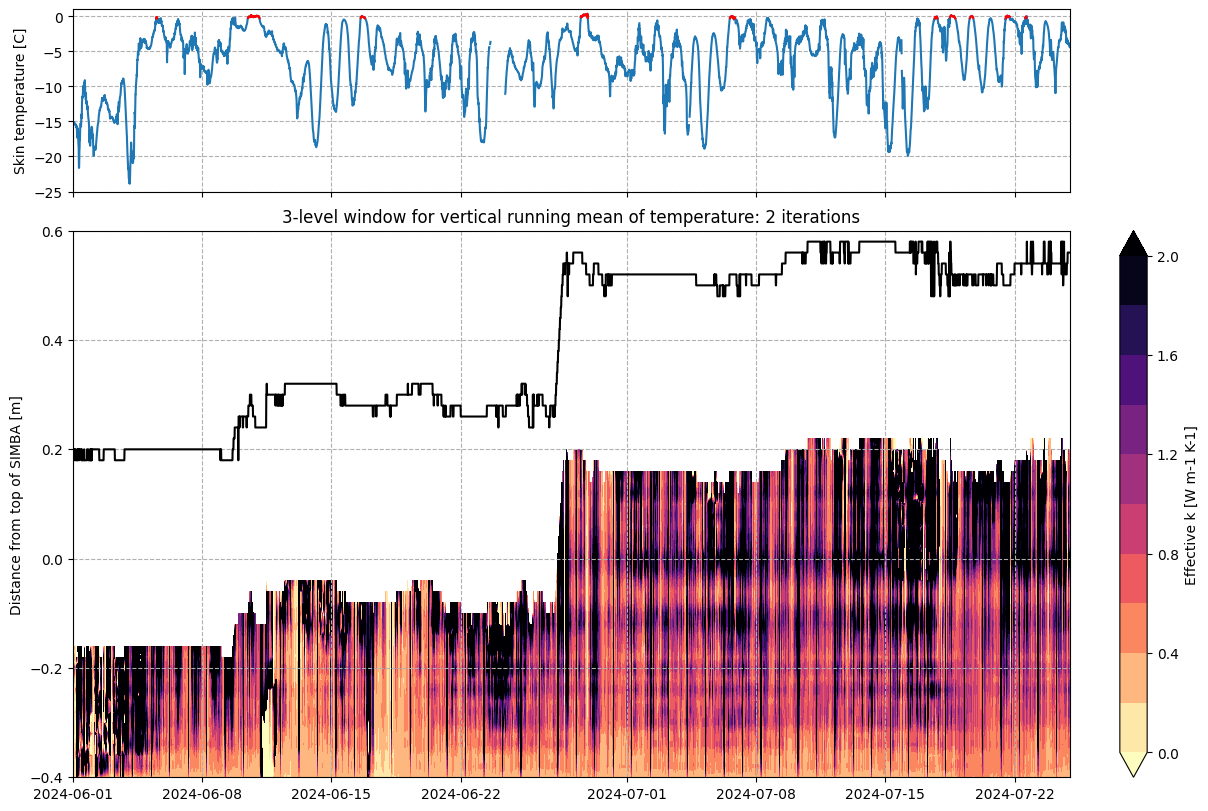

In [408]:
fig, axs = plt.subplots(2, figsize=(12,8), sharex=True, constrained_layout=True, gridspec_kw=dict(height_ratios=[1, 3]))

# axs[1].fill_between(plt_times, rnd_sfc, rnd_sfc-.32, color='lightgray')

# cb = axs[1].contourf(plt_times, imb_depth_m[padded_depth_idx][:-1], np.swapaxes(np.ma.masked_invalid(k_2d),0,1),
cb = axs[1].contourf(plt_times, imb_depth_m, np.swapaxes(np.ma.masked_invalid(k_2d),0,1),
                cmap=plt.cm.magma_r, levels=np.arange(0,2.01,.2), extend='both')
plt.colorbar(cb, label='Effective k [W m-1 K-1]', ax=axs[1])

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')

axs[0].set_ylabel('Skin temperature [C]')
axs[0].set_ylim(-25,1)
axs[1].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for ax in axs.ravel():
    ax.grid(ls='--')
axs[1].set_ylabel('Distance from top of SIMBA [m]')
# axs[1].set_title('Smoothed temperatures, masking |$T_t-T_{t-1}$|<=0.0625')
axs[1].set_title('3-level window for vertical running mean of temperature: 2 iterations')


axs[1].plot(plt_times, rnd_sfc, c='k')
# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[1].set_ylim(-.4,.6)
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_keff-profile-timeseries_skinT_3level-smoothing-window_2iterations.png', dpi=250)
plt.show()

### ADDING SOLAR TERM!!!

In [504]:

## rename these!
k_2d = []
# rho_2d = []
# S_2d = []
# Fc_2d = []
# Fc_div_2d = []

plt_times = []
plt_secs = []
plt_bad_timesteps = []

rnd_sfc = []
# fig, axs = plt.subplots(1,4, figsize=(9,6), sharey=True)
# axs[0].set_ylabel('Height from top of chain [m]')

# t_idx = date_idx_imb[1]


dt_step = 1

sfc_pad =  0. #.35

# for dt_step in [1,4,2*4,3*4]:
for _, t_idx in np.ndenumerate(date_idx_imb[1:]):
# for _, t_idx in np.ndenumerate(date_idx_imb[131:133]):

        all_depths_K = []
        # all_depths_rho = []
        # all_depths_S = []
        # all_depths_Fc = []
        # all_depths_Fc_div = []

        sfc_level = round_up_to_even(simba_sfc[t_idx])/100.
        # sfc_level = 0.2
        
        depth_idx = np.where((imb_depth_m<(sfc_level-sfc_pad))&(imb_depth_m>=bottom_height))

        # added 1/27/25 to try and remove time steps where dT/dz==0
        # if np.all(smoothed_dTdz[t_idx,:] == 0):
        #     k_2d.append( np.full((np.where( (imb_depth_m<-2.8)&(imb_depth_m>=-3.98) )[0].shape), -999) )
        #     plt_times.append(season_data['dates'][t_idx])
        #     continue


        ### THIS WONT WORK WHEN SFC_PAD>0!!!!
        sw_abs, _ = calc_sw_abs_single(interpolated_fp['net_short_hemisp'][t_idx], 25., imb_depth_m[depth_idx], dpth_st=sfc_level)
        # print(sw_abs)
        # print(imb_depth_m[depth_idx])
        # print()
        # sw_abs *= 0.
    
        # depth_idx = np.where((imb_depth_m<sfc_level-.3)&(imb_depth_m>=bottom_height))
        rho = np.full(imb_depth_m.shape, 300.)

        try:
            K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles_solar(smoothed_temp[:,:],
                                    imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, sw_abs,
                                    bc_flx=-interpolated_fp['subsurface_heat_flux_B'][t_idx], 
                                    ) # bc_flx = 'boundary condition flux', this number comes from looking at time series of flux plates in earlier version of this code. will eventually want to connect this to the actual measured flux
        except:
            print('failed to converge')
        # axs[0].plot(np.squeeze(smoothed_temp[t_idx, depth_idx]), imb_depth_m[depth_idx], label=dt_step)#'t=0')
    
        # axs[1].plot(np.squeeze(smoothed_temp[t_idx+dt_step, depth_idx]-smoothed_temp[t_idx, depth_idx]), imb_depth_m[depth_idx])
        # axs[2].plot(np.squeeze(smoothed_dTdz[t_idx, depth_idx]), imb_depth_m[depth_idx])
        # axs[3].plot(K, imb_depth_m[depth_idx][:-1])

        pad_top = [-999 for _ in np.where( (imb_depth_m<=imb_depth_m.max())&(imb_depth_m>=(sfc_level-sfc_pad)) )[0]]
        pad_bottom = [-999 for _ in np.where( (imb_depth_m>=imb_depth_m.min())&(imb_depth_m<=bottom_height) )[0]]

        # pad_top = np.full( int((imb_depth[0]-(sfc_level*100.))/2+1) ,-999)
        # pad_bottom = np.full(int((bottom_height*100.-imb_depth[-1])/2+1),-999)
        # print(season_data['dates'][t_idx], sfc_level, imb_depth_m.max(), len(pad_top), len(pad_bottom), len(K), len(pad_top)+len(pad_bottom)+len(K))
        print(season_data['dates'][t_idx], sfc_level, len(depth_idx[0]), len(pad_top), len(K), len(pad_top)+len(pad_bottom)+len(K))

        # print(K.shape)#, imb_depth_m[depth_idx].shape, temp_kelv[:,depth_idx].shape)
        if type(K)!=bool:
            # k_2d_not_smooth.append(np.ma.concatenate( (padding,np.squeeze(K)) ))
            plt_times.append(season_data['dates'][t_idx])
            rnd_sfc.append(sfc_level)
            # print(np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(K), pad_bottom),axis=0)), axis=0).shape )
            # print()
            k_2d.append( np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(K), pad_bottom),axis=0)), axis=0) )
            # rho_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (rho_n, pad_bottom),axis=0)),axis=0) )
            # S_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (np.squeeze(S)[:-1], pad_bottom),axis=0)),axis=0) )
            # Fc_2d.append(np.ma.concatenate( (pad_top, np.ma.concatenate( (Fc, pad_bottom),axis=0)),axis=0) )
            
            # all_depths_rho.append( np.ma.concatenate( (padding,rho_n) ))
            # all_depths_S.append( np.ma.concatenate( (padding,np.squeeze(S)[:-1]) ))
            # all_depths_Fc.append( np.ma.concatenate( (padding,Fc) ))
            
            # len_ld = len(depth_idx[0])

# axs[0].legend(loc='best')
# #for ax, label in zip(axs.ravel(), ['Temp [K]', 'dT/dt', 'dT/dz','k']):
# for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]','k']):
#     ax.set_xlabel(label)
#     ax.grid(alpha=.5, ls='--')
#     ax.axhline(y=sfc_height-.3, c='k')

# # axs[-1].set_xlim(-1,1)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'-'+en_date.strftime('%H:%M'))
# #plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d:%H:%M')+'-'+en_date.strftime('%H:%M')+'.png', dpi=200)
# plt.show()

2024-05-20 00:30:00 0.0 21 101 20 160
2024-05-20 00:45:00 0.0 21 101 20 160
2024-05-20 01:00:00 0.0 21 101 20 160
2024-05-20 01:15:00 0.0 21 101 20 160
2024-05-20 01:30:00 0.0 21 101 20 160
2024-05-20 01:45:00 0.0 21 101 20 160
2024-05-20 02:00:00 0.0 21 101 20 160
2024-05-20 02:15:00 0.0 21 101 20 160
2024-05-20 02:30:00 0.0 21 101 20 160
2024-05-20 02:45:00 0.0 21 101 20 160
2024-05-20 03:00:00 0.0 21 101 20 160
2024-05-20 03:15:00 0.0 21 101 20 160
2024-05-20 03:30:00 0.0 21 101 20 160
2024-05-20 03:45:00 0.0 21 101 20 160
2024-05-20 04:00:00 0.0 21 101 20 160
2024-05-20 04:15:00 0.0 21 101 20 160
2024-05-20 04:30:00 0.0 21 101 20 160
2024-05-20 04:45:00 0.0 21 101 20 160
2024-05-20 05:00:00 0.0 21 101 20 160
2024-05-20 05:15:00 0.0 21 101 20 160
2024-05-20 05:30:00 0.0 21 101 20 160
2024-05-20 05:45:00 0.0 21 101 20 160
2024-05-20 06:00:00 0.0 21 101 20 160
2024-05-20 06:15:00 0.0 21 101 20 160
2024-05-20 06:30:00 0.0 21 101 20 160
2024-05-20 06:45:00 0.0 21 101 20 160
2024-05-20 0

In [505]:
k_2d = np.ma.masked_equal(k_2d, -999)
rnd_sfc = np.asarray(rnd_sfc)

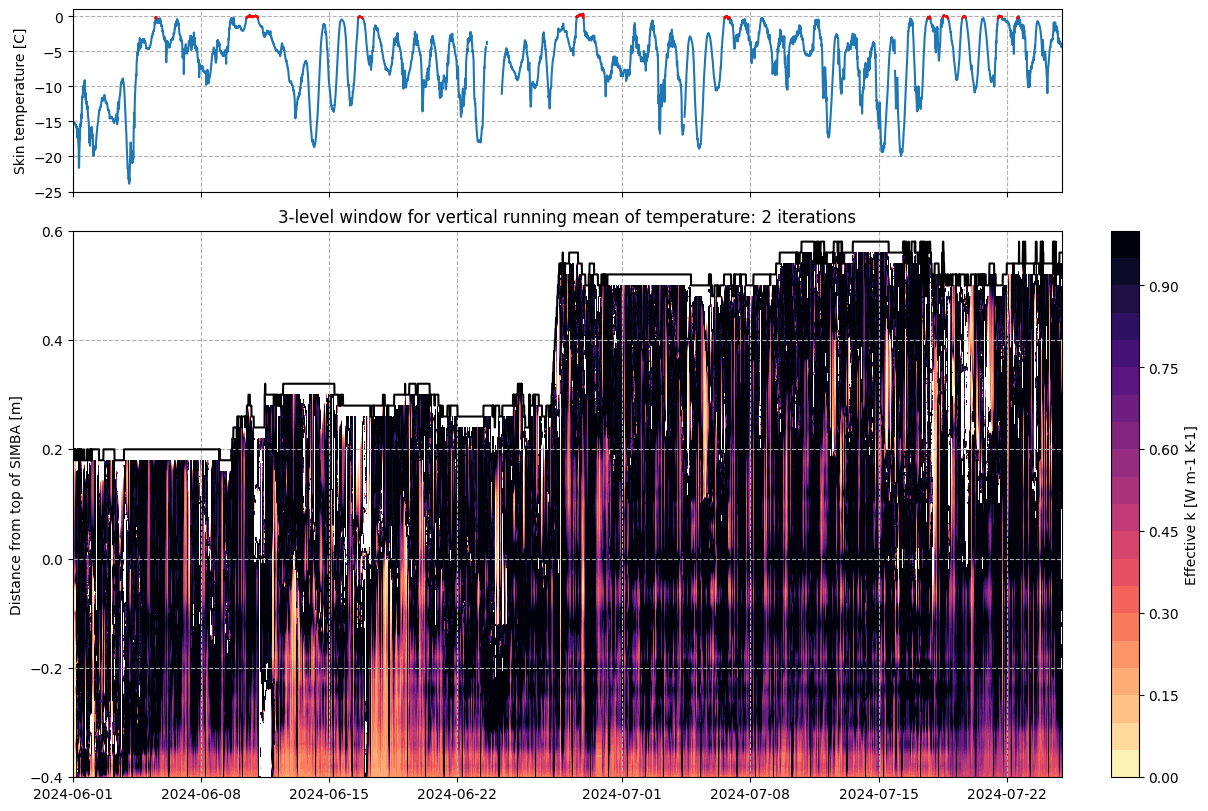

In [507]:
fig, axs = plt.subplots(2, figsize=(12,8), sharex=True, constrained_layout=True, gridspec_kw=dict(height_ratios=[1, 3]))

# axs[1].fill_between(plt_times, rnd_sfc, rnd_sfc-.32, color='lightgray')

# cb = axs[1].contourf(plt_times, imb_depth_m[padded_depth_idx][:-1], np.swapaxes(np.ma.masked_invalid(k_2d),0,1),
# cb = axs[1].contourf(plt_times, imb_depth_m, np.swapaxes(np.ma.masked_invalid(np.ma.masked_greater(k_2d,1)),0,1),
cb = axs[1].contourf(plt_times, imb_depth_m, np.swapaxes(np.ma.masked_invalid(k_2d),0,1),
                cmap=plt.cm.magma_r, levels=np.arange(0,1.01,.05))#, extend='both')
plt.colorbar(cb, label='Effective k [W m-1 K-1]', ax=axs[1])

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')

axs[0].set_ylabel('Skin temperature [C]')
axs[0].set_ylim(-25,1)
axs[1].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for ax in axs.ravel():
    ax.grid(ls='--')
axs[1].set_ylabel('Distance from top of SIMBA [m]')
# axs[1].set_title('Smoothed temperatures, masking |$T_t-T_{t-1}$|<=0.0625')
axs[1].set_title('3-level window for vertical running mean of temperature: 2 iterations')


axs[1].plot(plt_times, rnd_sfc, c='k')
# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[1].set_ylim(-.4,.6)
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_keff-profile-timeseries_skinT_3level-smoothing-window_2iterations.png', dpi=250)
plt.show()

In [492]:
## example of single level: interpolate then smooth?
plt_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in plt_times])

## need to get single depth
k2d_plt_depth = imb_depth_m[:-1]
copy_keff_dpth = np.squeeze(np.ma.masked_outside(copy_keff, 0, 3)[:, np.where(k2d_plt_depth==-3.62)[0]])

f_k = interpolate.interp1d(plt_seconds[~copy_keff_dpth.mask], copy_keff_dpth[~copy_keff_dpth.mask], fill_value='extrapolate')
interpolated_copy_keff_dpth = np.ma.masked_greater(f_k(plt_seconds), 3)



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

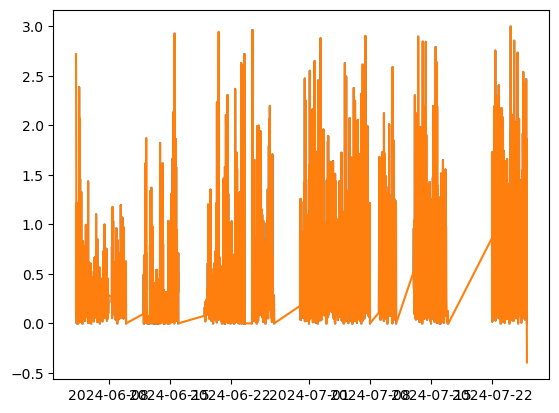

In [68]:
plt.plot(plt_times, copy_keff_dpth)
plt.plot(plt_times, interpolated_copy_keff_dpth)

plt.show()

Test what 'despiking' looks like: remove points that are outside running mean +/- some multiple of standard deviation

4071 3869


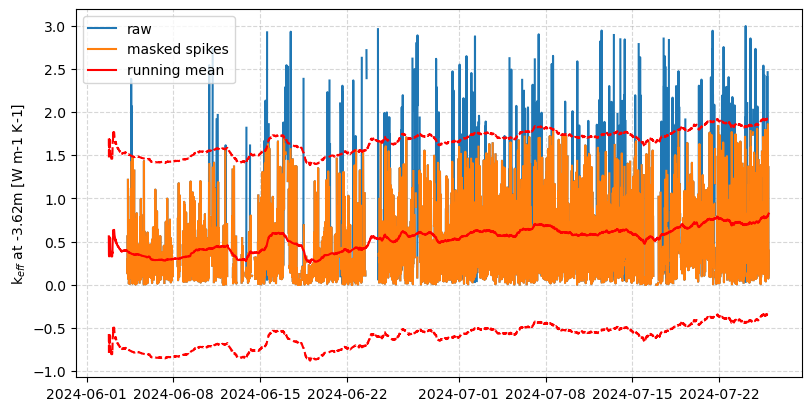

In [69]:
## single level
k_dpth = np.squeeze(np.ma.masked_invalid(k_2d)[:, np.where(k2d_plt_depth==-3.62)[0]])

# smooth it
d = 3 # number of days for smoothing
kernel_days= [1./(4*24*d+1)]*(4*24*d+1)
k_smoothed = convolve(k_dpth, kernel_days, boundary='extend')

# remove spiky points
k_dpth_std = k_dpth.std()

hi_range = k_smoothed+2.*k_dpth_std
lo_range = k_smoothed-2.*k_dpth_std
despiked_k_dpth = np.ma.masked_where(k_dpth>hi_range, k_dpth)
despiked_k_dpth = np.ma.masked_where(k_dpth<lo_range, despiked_k_dpth)


print(k_dpth.count(), despiked_k_dpth.count())
fig, ax = plt.subplots(1, figsize=(8,4), constrained_layout=True,)

plt.plot(plt_times, k_dpth, label='raw')
plt.plot(plt_times, despiked_k_dpth, label='masked spikes')

plt.plot(plt_times, k_smoothed, label='running mean', c='r')
plt.plot(plt_times, hi_range, c='r', ls='--')
plt.plot(plt_times, lo_range, c='r', ls='--')
plt.grid(alpha=.5, ls='--')
plt.legend(loc='best')
plt.ylabel('k$_{eff}$ at -3.62m [W m-1 K-1]')
plt.show()

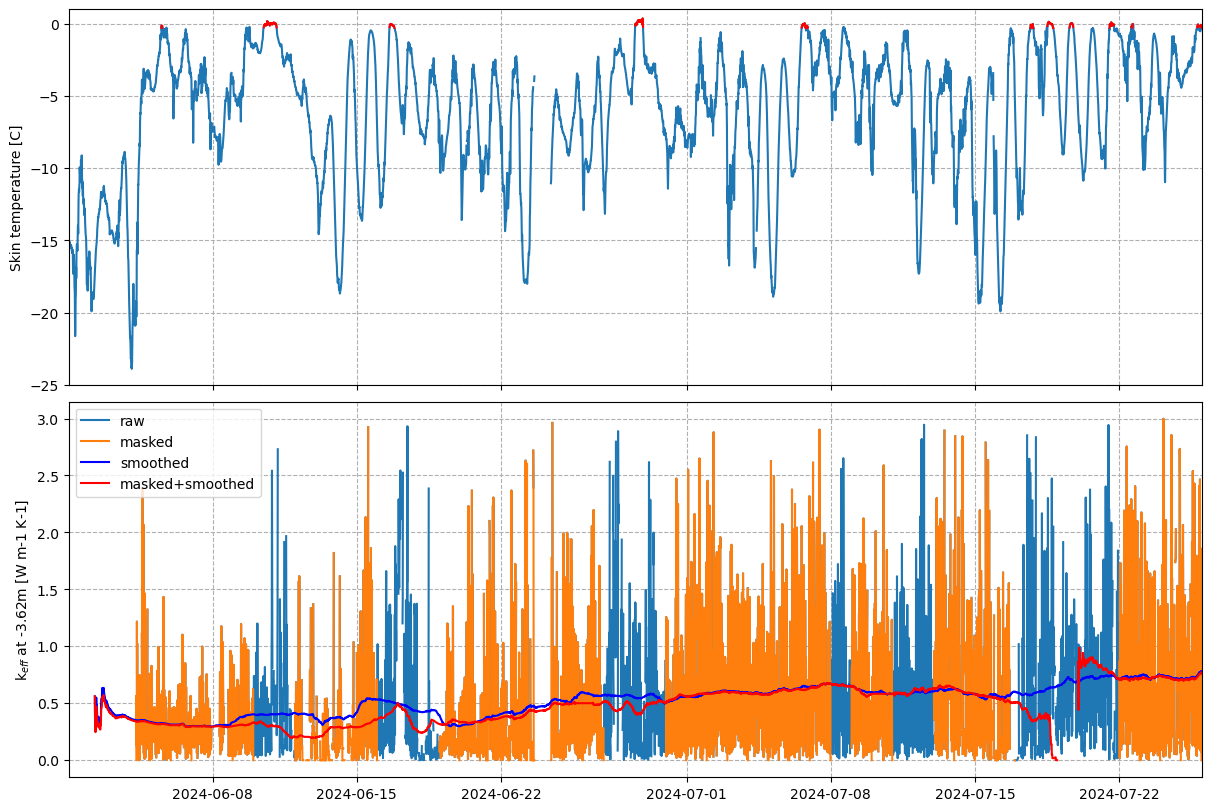

In [70]:
fig, axs = plt.subplots(2, figsize=(12,8), sharex=True, constrained_layout=True,)


axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')

axs[0].set_ylabel('Skin temperature [C]')
axs[0].set_ylim(-25,1)
axs[1].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for ax in axs.ravel():
    ax.grid(ls='--')

k2d_plt_depth = imb_depth_m[padded_depth_idx][:-1]
k_dpth = np.squeeze(np.ma.masked_invalid(k_2d)[:, np.where(k2d_plt_depth==-3.62)[0]])

# smooth it
kernel_days= [1./(4*24*4+1)]*(4*24*4+1)
k_smoothed = convolve(k_dpth, kernel_days, boundary='extend')

axs[1].plot(plt_times, k_dpth, c='tab:blue', label='raw')

axs[1].plot(plt_times, copy_keff_dpth, label='masked', c='tab:orange')
k_smoothed_masked = convolve(copy_keff_dpth, kernel_days, boundary='extend')

axs[1].plot(plt_times, k_smoothed, c='b', label='smoothed')
axs[1].plot(plt_times, k_smoothed_masked, c='r', label='masked+smoothed')

axs[1].legend(loc='best')
axs[1].set_ylabel('k$_{eff}$ at -3.62m [W m-1 K-1]')

axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])

# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_keff-profile-timeseries_skinT_3level-smoothing-window_2iterations.png', dpi=250)
plt.show()

Back to previous flux investigations...

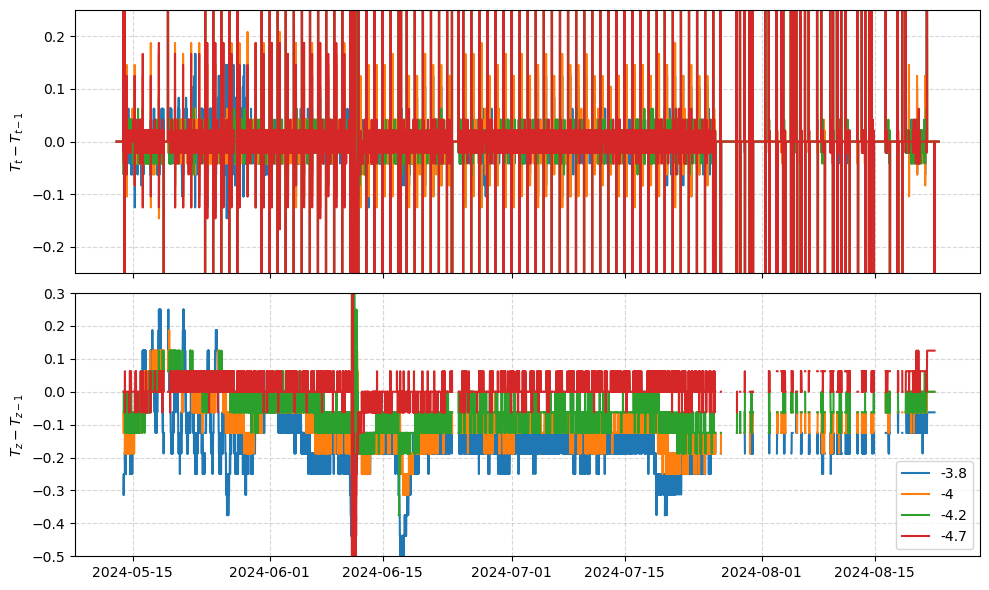

In [71]:
# what did temperature gradients look like at level of flux plates throughout summer?
fig, axs = plt.subplots(2, figsize=(10,6), sharex=True)

for var, xvar, ax, label in zip([smoothed_dTdt, dTdz], [season_data['dates'][:-1], season_data['dates']], axs.ravel(), ['$T_t-T_{t-1}$','$T_z-T_{z-1}$']):
    for depth in [-3.8, -4, -4.2, -4.7]:
        ax.plot(xvar, var[:,np.where(imb_depth_m==depth)[0]], label=depth)
    ax.set_ylabel(label)
    ax.grid(alpha=.5, ls='--')

axs[0].set_ylim(-.25,.25)
axs[1].set_ylim(-.5,.3)
# axs[1].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,20))

axs[1].legend(loc='best')
plt.tight_layout()
plt.show()


What do time series of flux plates look like? Also, what is the sign of the flux plates?

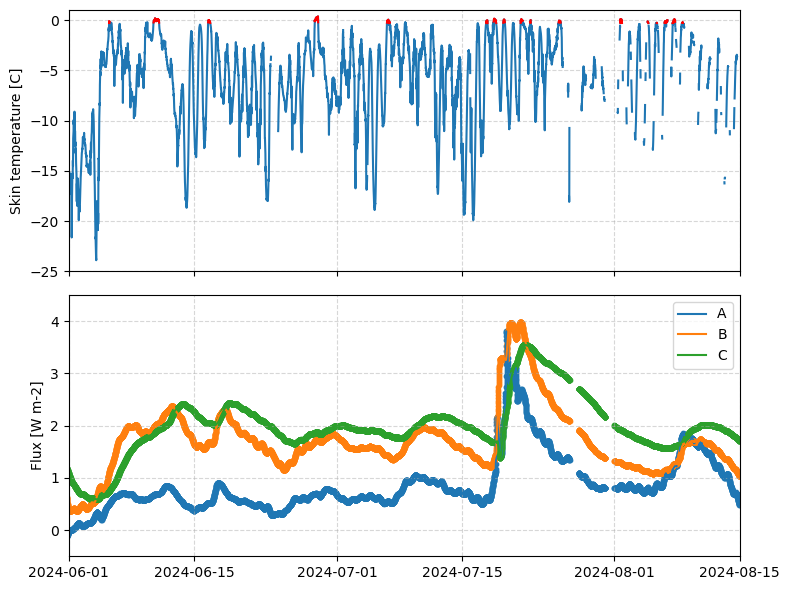

In [33]:
fig, axs = plt.subplots(2, figsize=(8,6), sharex=True)

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')

axs[0].set_ylim(-25,1)

for fp in ['A','B','C']:
    axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['subsurface_heat_flux_'+fp], label=fp)
    axs[1].scatter(season_data['dates'], interpolated_fp['subsurface_heat_flux_'+fp], s=10)

axs[1].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,8,15))
axs[1].set_ylim(-.5,4.5)
axs[1].legend(loc='best')
axs[1].set_ylabel('Flux [W m-2]')
axs[0].set_ylabel('Skin temperature [C]')

for ax in axs.ravel():
    ax.grid(alpha=.5, ls='--')
plt.tight_layout()
plt.show()

In [34]:
print(np.shape(date_idx_imb), np.shape(smoothed_dTdt), np.shape(k_2d), np.shape(np.squeeze(smoothed_dTdt[:,depth_idx[1:]])))

(5279,) (9503, 241) (5279, 59) (9503, 0)


## Use keff to calculate flux and compare to flux plates
Should go back and carefully check depths for k_2d from derivation!

In [35]:
k_2d = np.ma.masked_invalid(k_2d)
k_2d = np.ma.masked_outside(k_2d, 0, 3)
k_2d = np.ma.masked_equal(k_2d, 0)

In [36]:
# dTdz_depth_idx = np.where((imb_depth_m[1:]<sfc_height-.3)&(imb_depth_m[1:]>=bottom_height))[0]
dTdz_depth_idx = padded_depth_idx[0]
print(np.shape(dTdz_depth_idx))

(60,)


In [37]:
dTdz_subset = np.squeeze(smoothed_dTdz[:,dTdz_depth_idx[:-1]])[date_idx_imb,:]/0.02

In [38]:
smoothed_FC = -k_2d*dTdz_subset

In [39]:
fpC_depth_idx = np.where(imb_depth_m[dTdz_depth_idx[:-1]]==-3.8)[0] ## flux plate C @ therm #190 -> -190.*2/100=-3.8m
print(imb_depth_m[dTdz_depth_idx[:-1]][fpC_depth_idx])

fpB_depth_idx = np.where(imb_depth_m[dTdz_depth_idx[:-1]]==-3.98)[0] ## flux plate B 1cmbelow therm #200 -> -200.*2/100=4. but that's the last level that's cut off in the derivation?
print(imb_depth_m[dTdz_depth_idx[:-1]][fpB_depth_idx])

[-3.8]
[-3.98]


In [40]:
# Mask points above the snow-atmosephere interface
# need to get surface and depths to be same shapes
sfc_repeat = np.repeat(rnd_sfc[:,np.newaxis], dTdz_subset.shape[1], axis=1)
depth_repeat = np.repeat(imb_depth_m[padded_depth_idx][:-1][np.newaxis,:], dTdz_subset.shape[0], axis=0)

print(dTdz_subset.shape, depth_repeat.shape, sfc_repeat.shape)

dTdz_subset_masked = np.ma.masked_where(depth_repeat>sfc_repeat, dTdz_subset)

(5279, 59) (5279, 59) (5279, 59)


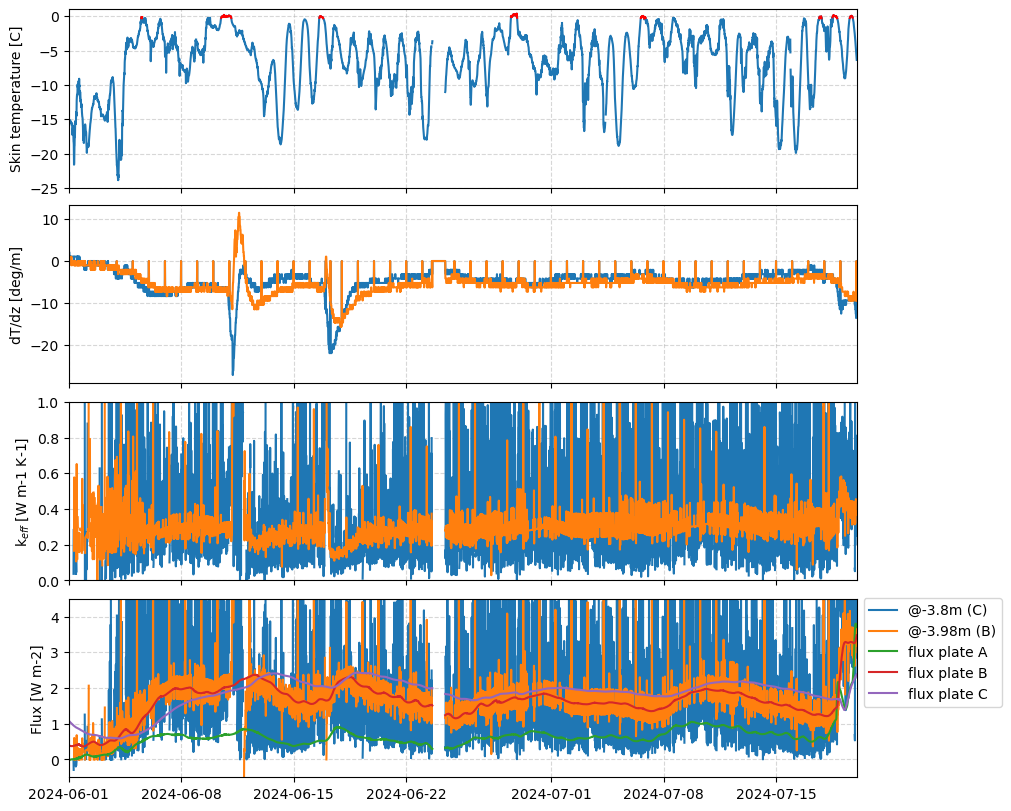

In [41]:
fig, axs = plt.subplots(4, figsize=(10,8), sharex=True, constrained_layout=True)

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')


axs[1].plot(plt_times, dTdz_subset[:,fpC_depth_idx], label='@-3.8m')
axs[1].plot(plt_times, dTdz_subset[:,-1], label='@-3.98m')

axs[2].plot(plt_times, k_2d[:,fpC_depth_idx])
axs[2].plot(plt_times, k_2d[:,-1], label='@-3.98m')

axs[3].plot(plt_times, smoothed_FC[:,fpC_depth_idx], label='@-3.8m (C)')
axs[3].plot(plt_times, smoothed_FC[:,-1], label='@-3.98m (B)')

axs[3].plot(asfs_data_lev2['dates'], asfs_data_lev2['subsurface_heat_flux_A'], label='flux plate A')
axs[3].plot(asfs_data_lev2['dates'], asfs_data_lev2['subsurface_heat_flux_B'], label='flux plate B')
axs[3].plot(asfs_data_lev2['dates'], asfs_data_lev2['subsurface_heat_flux_C'], label='flux plate C')

axs[3].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,20))
axs[3].set_ylim(-.5,4.5)
axs[3].legend(bbox_to_anchor=(1.,.7), loc='center left')

axs[2].set_ylim(0,1)
axs[0].set_ylim(-25,1)

labels = ['Skin temperature [C]', 'dT/dz [deg/m]', 'k$_{eff}$ [W m-1 K-1]', 'Flux [W m-2]']

for ax, label in zip(axs.ravel(), labels):
    ax.grid(alpha=.5, ls='--')
    ax.set_ylabel(label)

plt.show()

How to "postprocess" k? Currently removing values outside of (0,3) and equal to 0.

What's with the zero values in orange dT/dz? Need to skip in retrieval? or mask in "postprocess"?

What's the accuracy/precision of the flux plates?

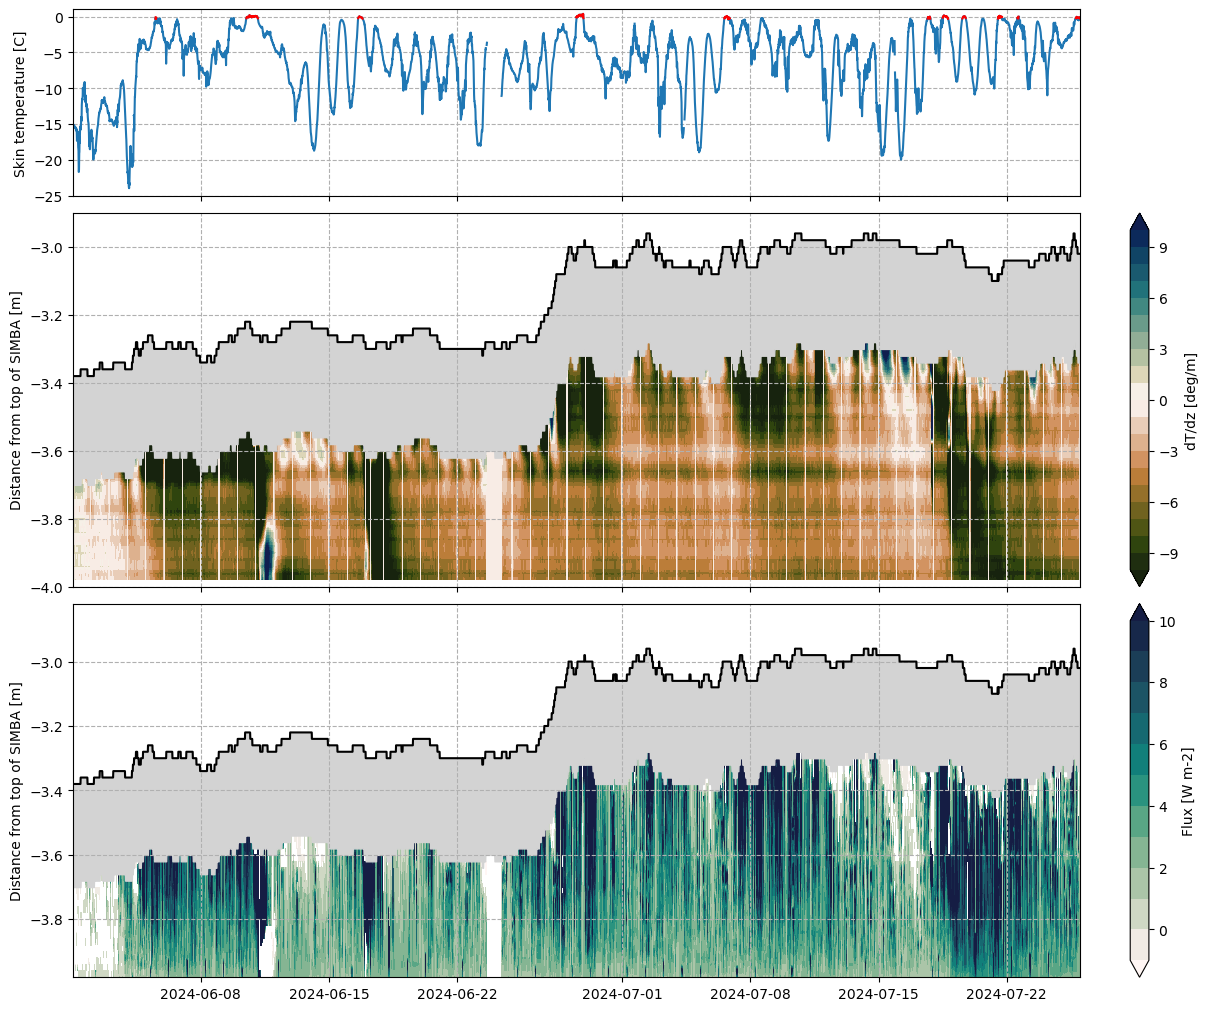

In [42]:
fig, axs = plt.subplots(3, figsize=(12,10), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]))
cb = axs[1].contourf(plt_times, imb_depth_m[padded_depth_idx][:-1], np.swapaxes(np.ma.masked_invalid(dTdz_subset_masked),0,1),
                cmap=cmocean.cm.tarn, levels=np.arange(-10,11,1), extend='both')
plt.colorbar(cb, label='dT/dz [deg/m]', ax=axs[1])

cb = axs[2].contourf(plt_times, imb_depth_m[padded_depth_idx][:-1], np.swapaxes(np.ma.masked_invalid(smoothed_FC),0,1),
                cmap=cmocean.cm.tempo, levels=np.arange(-1,11,1), extend='both')
plt.colorbar(cb, label='Flux [W m-2]', ax=axs[2])

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')
    if i>0:
        ax.set_ylabel('Distance from top of SIMBA [m]')

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')

axs[0].set_ylabel('Skin temperature [C]')
# axs[1].set_title('Smoothed temperatures, masking |$T_t-T_{t-1}$|<=0.0625')

axs[0].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,20))
axs[0].set_ylim(-25,1)


axs[1].fill_between(plt_times, rnd_sfc, rnd_sfc-.32, color='lightgray')
axs[2].fill_between(plt_times, rnd_sfc, rnd_sfc-.32, color='lightgray')

axs[1].plot(plt_times, rnd_sfc, c='k')
axs[2].plot(plt_times, rnd_sfc, c='k')

axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[1].set_ylim(bottom_height,-2.9)
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)

plt.show()

#### Switching gears a little bit to get sense of temperature changes over time and over upper 30cm

In [43]:
dTdt_subset_masked = np.ma.masked_where(depth_repeat>sfc_repeat, smoothed_dTdt[:,dTdz_depth_idx[:-1]][date_idx_imb,:])
cumul_temp = np.ma.cumsum(dTdt_subset_masked, axis=0)

## cumsum sums all preceding values along the axis in the same way as the following:
##
## for i in range(dTdt_subset_masked.shape[0]):
##    cumul_temp[i,:] = np.ma.sum(dTdt_subset_masked[:i,:], axis=0)


print(dTdt_subset_masked.shape, cumul_temp.shape)

(5279, 59) (5279, 59)


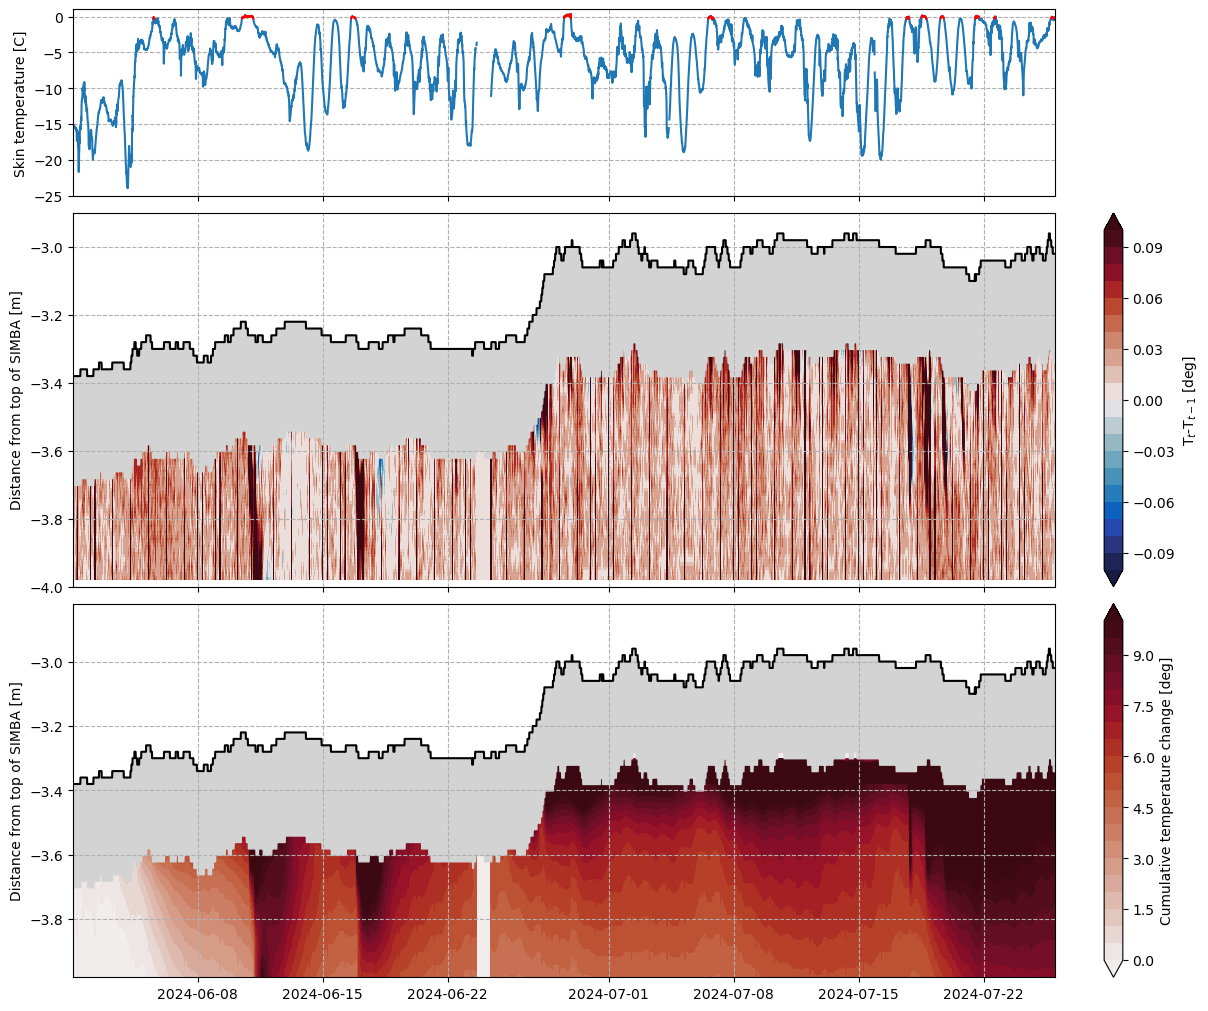

In [44]:
fig, axs = plt.subplots(3, figsize=(12,10), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,2,2]))
cb = axs[1].contourf(plt_times, imb_depth_m[padded_depth_idx][:-1], np.swapaxes(np.ma.masked_invalid(dTdt_subset_masked),0,1),
                cmap=cmocean.cm.balance, levels=np.arange(-.1,.11,.01), extend='both')
plt.colorbar(cb, label='T$_{t}$-T$_{t-1}$ [deg]', ax=axs[1])

cb = axs[2].contourf(plt_times, imb_depth_m[padded_depth_idx][:-1], np.swapaxes(np.ma.masked_invalid(cumul_temp),0,1),
                cmap=cmocean.cm.amp, levels=np.arange(0,10.1,.5), extend='both')
plt.colorbar(cb, label='Cumulative temperature change [deg]', ax=axs[2])

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')
    if i>0:
        ax.set_ylabel('Distance from top of SIMBA [m]')

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')

axs[0].set_ylabel('Skin temperature [C]')
# axs[1].set_title('Smoothed temperatures, masking |$T_t-T_{t-1}$|<=0.0625')

axs[0].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,20))
axs[0].set_ylim(-25,1)


axs[1].fill_between(plt_times, rnd_sfc, rnd_sfc-.32, color='lightgray')
axs[2].fill_between(plt_times, rnd_sfc, rnd_sfc-.32, color='lightgray')

axs[1].plot(plt_times, rnd_sfc, c='k')
axs[2].plot(plt_times, rnd_sfc, c='k')

axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[1].set_ylim(bottom_height,-2.9)
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)

plt.show()

### Testing the impact of how many times to iterate in retrieval

iterated_retrievals = {}

for iteration in [1,2,3,4,5,6]:
    ## rename these!
    k_2d = []
    plt_times = []
    rnd_sfc = []
    
    dt_step = 1
    
    for _, t_idx in np.ndenumerate(date_idx_imb[:]):
            all_depths_K = []
            # all_depths_rho = []
            # all_depths_S = []
            # all_depths_Fc = []
            # all_depths_Fc_div = []
    
            sfc_level = round_up_to_even(simba_sfc[t_idx])/100.
            rnd_sfc.append(sfc_level)
    
            # added 1/27/25 to try and remove time steps where dT/dz==0
            if np.all(smoothed_dTdz[t_idx,:] == 0):
                k_2d.append( np.full((np.where( (imb_depth_m<-2.8)&(imb_depth_m>=-3.98) )[0].shape), -999) )
                plt_times.append(season_data['dates'][t_idx])
                continue
    
    
            depth_idx = np.where((imb_depth_m<sfc_level-.3)&(imb_depth_m>=bottom_height))
            rho = np.full(imb_depth_m.shape, 300.)
            
            K, rho_n, S, Fc_div, Fc, bad_top, det_0_num = calc_profiles(smoothed_temp[:,:],
                                        imb_secs[:], imb_depth_m, depth_idx, t_idx, rho, 
                                        bc_flx=-interpolated_fp['subsurface_heat_flux_B'][t_idx], 
                                        dt=dt_step, mask_dT=False, its=iteration)
    
            padding = [-999 for _ in np.where( (imb_depth_m<-2.8)&(imb_depth_m>=sfc_level-.3) )[0]]
    
            if type(K)!=bool:
                # print(sd, len(K), len(depth_idx[0]))
                k_2d.append(np.ma.concatenate( (padding,np.squeeze(K)) ))
                plt_times.append(season_data['dates'][t_idx])

    iterated_retrievals[iteration] = {'dates':plt_times, 'keff':np.ma.masked_equal(k_2d, -999)}

fig, axs = plt.subplots(4, figsize=(10,16), sharex=True, sharey=True)

for i, ax in enumerate(axs.ravel()):

    cb = ax.contourf(iterated_retrievals[i+1]['dates'], imb_depth_m[padded_depth_idx][:-1], np.swapaxes(iterated_retrievals[i+1]['keff'],0,1),
                cmap=cmocean.cm.matter, levels=np.arange(0,2.1,.2), extend='both')
    ax.set_title('Iterations:'+str(i+1))
    ax.grid(ls='--')
    ax.set_ylabel('Distance from top of SIMBA [m]')
    plt.colorbar(cb, label='Effective k [W m-1 K-1]', ax=ax)

ax.set_ylim(-3.98,-3.2)
plt.tight_layout()
plt.show()

### checking linearity of near surface temperatures

In [45]:
test_lin = np.linspace(sleigh_tskin_all-273.15, -10., 30)
print(test_lin.shape, sleigh_tskin_all.shape)

(30, 12384) (12384,)


In [46]:
## getting temperature 30cm below surface
sfc_idx = np.where(depth_repeat==sfc_repeat)[0]
print(sfc_idx.shape)

(5279,)


print(np.where(depth_repeat[20,:]==sfc_repeat[20,:])[0])

In [47]:
print(depth_repeat.shape)

(5279, 59)


In [48]:
print(depth_repeat[sfc_idx].shape, np.shape(rnd_sfc))

(5279, 59) (5279,)


NEED TO ROUND TO NEAREST CM!!!

In [49]:
from decimal import *

In [50]:
## This is absollutely something I expected to be able to do with numpy, but it's not working at the moment...

# subsfc_temp = [smoothed_temp[t_idx,np.where(imb_depth_m==subsfc-.3)[0]] for t_idx, subsfc in zip(date_idx_imb, rnd_sfc)]
subsfc_temp = []
# subs = rnd_sfc-.30
for t_idx, subsfc in zip(date_idx_imb, rnd_sfc):
    
    subsfc_idx = np.where(imb_depth_m==round(subsfc-.3, 2))[0]
    if len(subsfc_idx)==0:
        print(subsfc, round(subsfc-.3, 2), subsfc_idx)
        subsfc_temp.append([-999])
    else:
        subsfc_temp.append(smoothed_temp[t_idx,subsfc_idx])

subsfc_temp = np.ma.squeeze(np.ma.masked_less(subsfc_temp,-100))
# print(len(subsfc_temp))

In [51]:
## need to get skin temperature to be same size as SIMBA time steps
# these were made above for interpolating flux plates:
# sleigh_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in asfs_data_lev2['dates']])
# simba_seconds = np.asarray([(t-datetime.datetime(1970,1,1)).total_seconds() for t in season_data['dates']])

f_0 = interpolate.interp1d(sleigh_seconds[~sleigh_tskin_all.mask], (sleigh_tskin_all-273.15)[~sleigh_tskin_all.mask], fill_value='extrapolate')
interp_tskin = f_0(simba_seconds)

In [52]:
print(interp_tskin[date_idx_imb].shape, subsfc_temp.shape)

(5279,) (5279,)


#### This isn't quite what I wanted/what I think it is!

In [53]:
## this is actually (theoretically) making linear changes between steps!
test_lin = np.linspace(interp_tskin[date_idx_imb], subsfc_temp-273.15, 15, axis=1, endpoint=True)
print(test_lin.shape, interp_tskin[date_idx_imb].shape)

(5279, 15) (5279,)


In [54]:
print(test_lin[900,:])

[-1.580648399320495 -1.8486973231785575 -2.11674624703662
 -2.384795170894683 -2.652844094752745 -2.920893018610808
 -3.1889419424688707 -3.456990866326933 -3.725039790184996
 -3.9930887140430587 -4.261137637901121 -4.529186561759184
 -4.7972354856172466 -5.065284409475309 -5.333333333333371]


In [55]:
## mask so that only slab is shown
dTdz_slab = np.ma.masked_where(depth_repeat>sfc_repeat, smoothed_dTdz[:,dTdz_depth_idx[:-1]][date_idx_imb,:])
dTdz_slab = np.ma.masked_where(depth_repeat<sfc_repeat-.3, dTdz_slab)


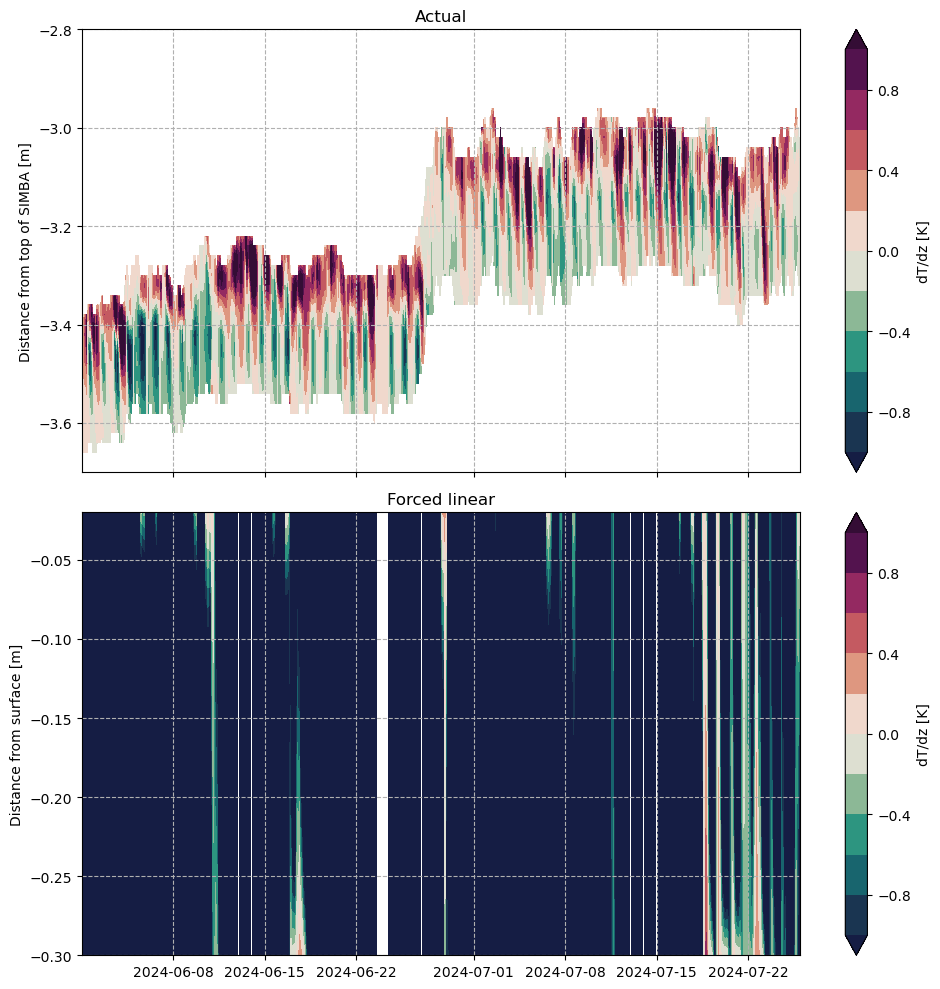

In [56]:
fig, axs = plt.subplots(2, figsize=(10,10), sharex=True,)

titles = ['Actual', 'Forced linear', ]
for i, (ax, data) in enumerate(zip(axs.ravel(), [test_lin, dTdz_slab])):
    ax.set_title(titles[i])
    ax.grid(ls='--')

cb = axs[0].contourf(plt_times, imb_depth_m[padded_depth_idx][:-1], np.swapaxes(dTdz_slab,0,1),
            cmap=cmocean.cm.curl, levels=np.arange(-1,1.01,.2), extend='both')
plt.colorbar(cb, label='dT/dz [K]', ax=axs[0])
axs[0].set_ylabel('Distance from top of SIMBA [m]')

axs[0].set_ylim(-3.7,-2.8)

cb = axs[1].contourf(plt_times, np.arange(-0.02,-.31,-.02), np.swapaxes(test_lin,0,1),
            cmap=cmocean.cm.curl, levels=np.arange(-1,1.01,.2), extend='both')
plt.colorbar(cb, label='dT/dz [K]', ax=axs[1])
axs[1].set_ylabel('Distance from surface [m]')


plt.tight_layout()
plt.show()

### Actually calculating storage here

In [57]:
c_p = 2090. # J/kg/C CHECK THIS WITH OTHER WORK!

In [58]:
Tskin_storage = interp_tskin[date_idx_imb]
seconds_storage = simba_seconds[date_idx_imb]
subsfc_temp -= 273.15# np.ma.masked_less(subsfc_temp, -100)-273.15

storage_sans_density = -c_p*(subsfc_temp[2:]-subsfc_temp[:-2] + Tskin_storage[2:]-Tskin_storage[:-2])/(2.*(seconds_storage[2:]-seconds_storage[:-2]))


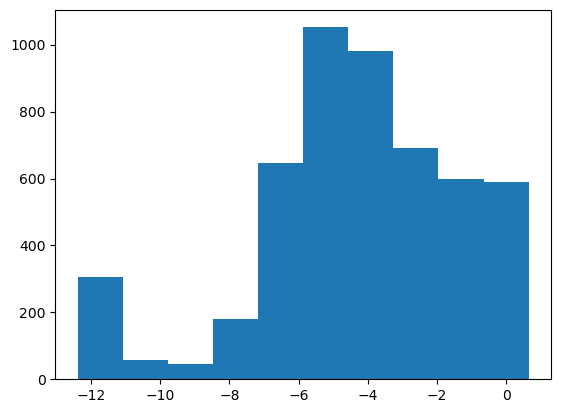

In [59]:
plt.hist(subsfc_temp[~subsfc_temp.mask])
plt.show()

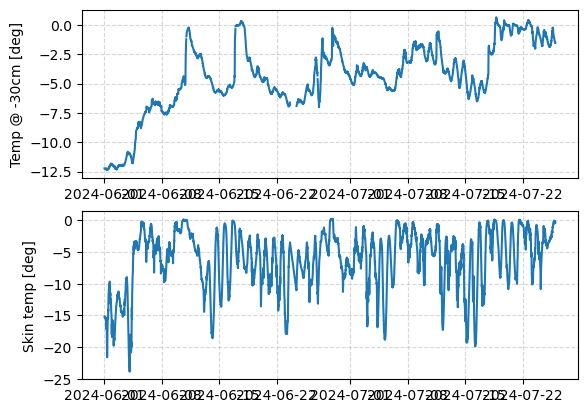

In [60]:
fig, axs = plt.subplots(2,)
labels = ['Temp @ -30cm [deg]', 'Skin temp [deg]']
for ax, var, label in zip(axs.ravel(), [subsfc_temp, Tskin_storage], labels):
    ax.plot(plt_times, var)
    ax.grid(ls='--', alpha=.5)
    ax.set_ylabel(label)

# axs[0].set_ylim(-40,0)
plt.show()

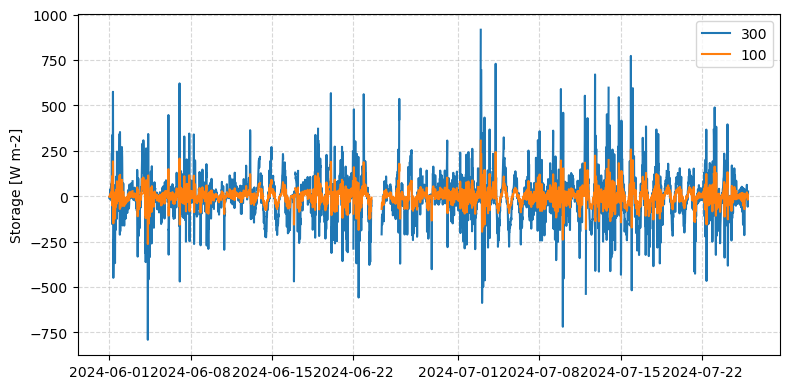

In [61]:
fig, ax = plt.subplots(1, figsize=(8,4))
for density in [300, 100]:
    plt.plot(plt_times[1:-1], density*storage_sans_density, label=density)

plt.ylabel('Storage [W m-2]')
plt.legend(loc='best')
plt.grid(ls='--', alpha=.5)
plt.tight_layout()
plt.show()

### Temperature and SWN

In [62]:
albedo = asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']

kernel_days= [1./(6*24*2+1)]*(6*24*2+1)

albedo_smoothed = convolve(albedo, kernel_days, boundary='extend')

/tmp/ipykernel_475791/393175486.py:9: UserWarning: The following kwargs were not used by contour: 'lw'
  cb = axs[2].contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),


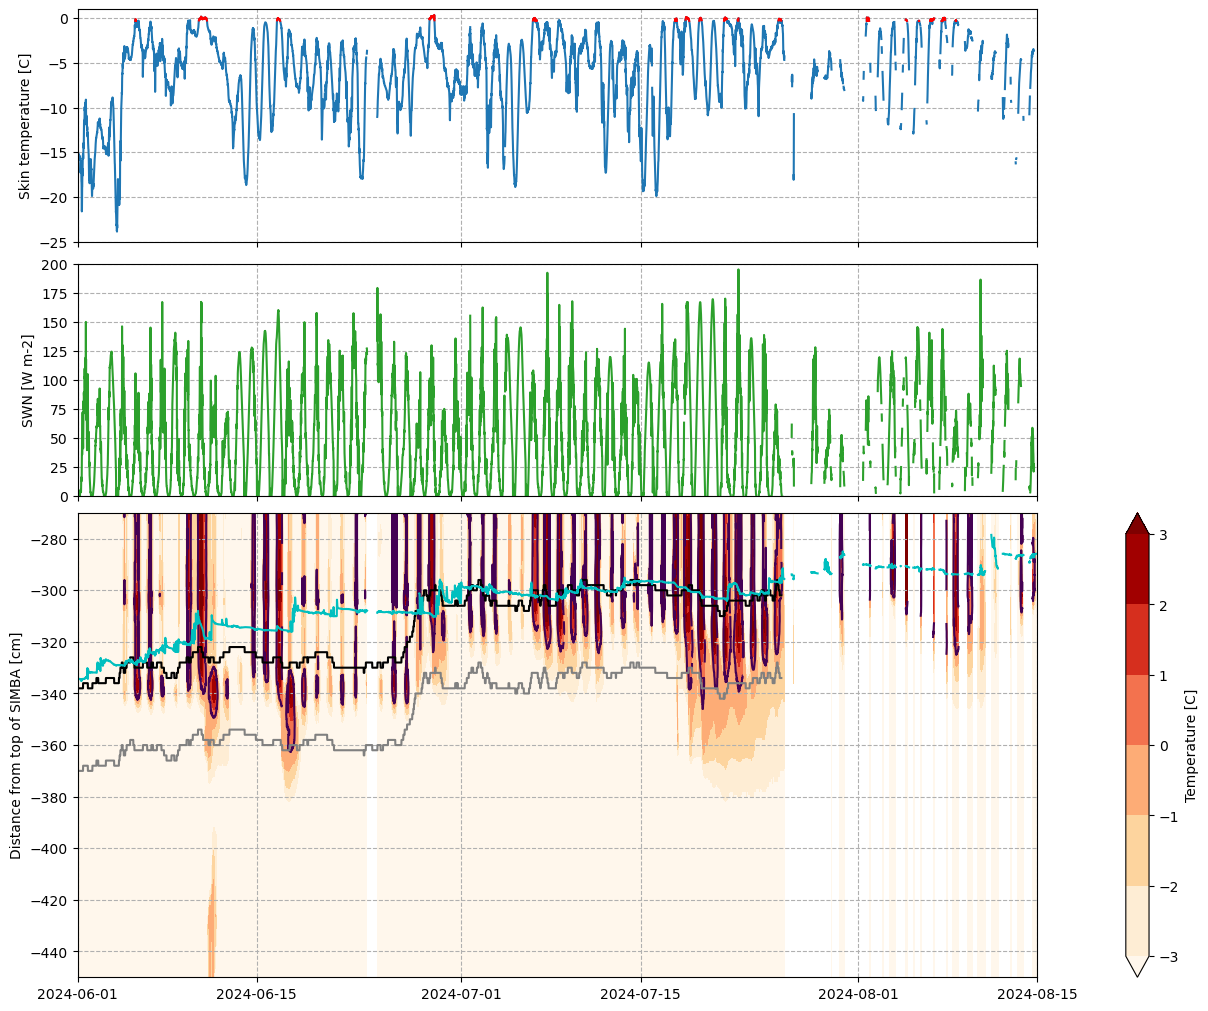

In [63]:
rnd_sfc = np.array(rnd_sfc)

fig, axs = plt.subplots(3, figsize=(12,10), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,1,2]))


cb = axs[2].contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
plt.colorbar(cb, ax=axs[2], label='Temperature [C]')
cb = axs[2].contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                levels=[0], extend='both', lw=1)
axs[2].set_ylabel('Distance from top of SIMBA [cm]')

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')
axs[0].set_ylabel('Skin temperature [C]')

axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_short_hemisp']-asfs_data_lev2['up_short_hemisp'], c='tab:green')
axs[1].set_ylabel('SWN [W m-2]')

axs[0].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,8,15))
axs[0].set_ylim(-25,1)


axs[2].plot(plt_times, 100.*rnd_sfc-32, color='gray')
axs[2].plot(plt_times, 100*rnd_sfc, c='k')
ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='c')

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[1].set_ylim(0,200)
axs[2].set_ylim(-450, -270)
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)

plt.show()

/tmp/ipykernel_475791/3579487376.py:7: UserWarning: The following kwargs were not used by contour: 'lw'
  cb = axs[-1].contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),


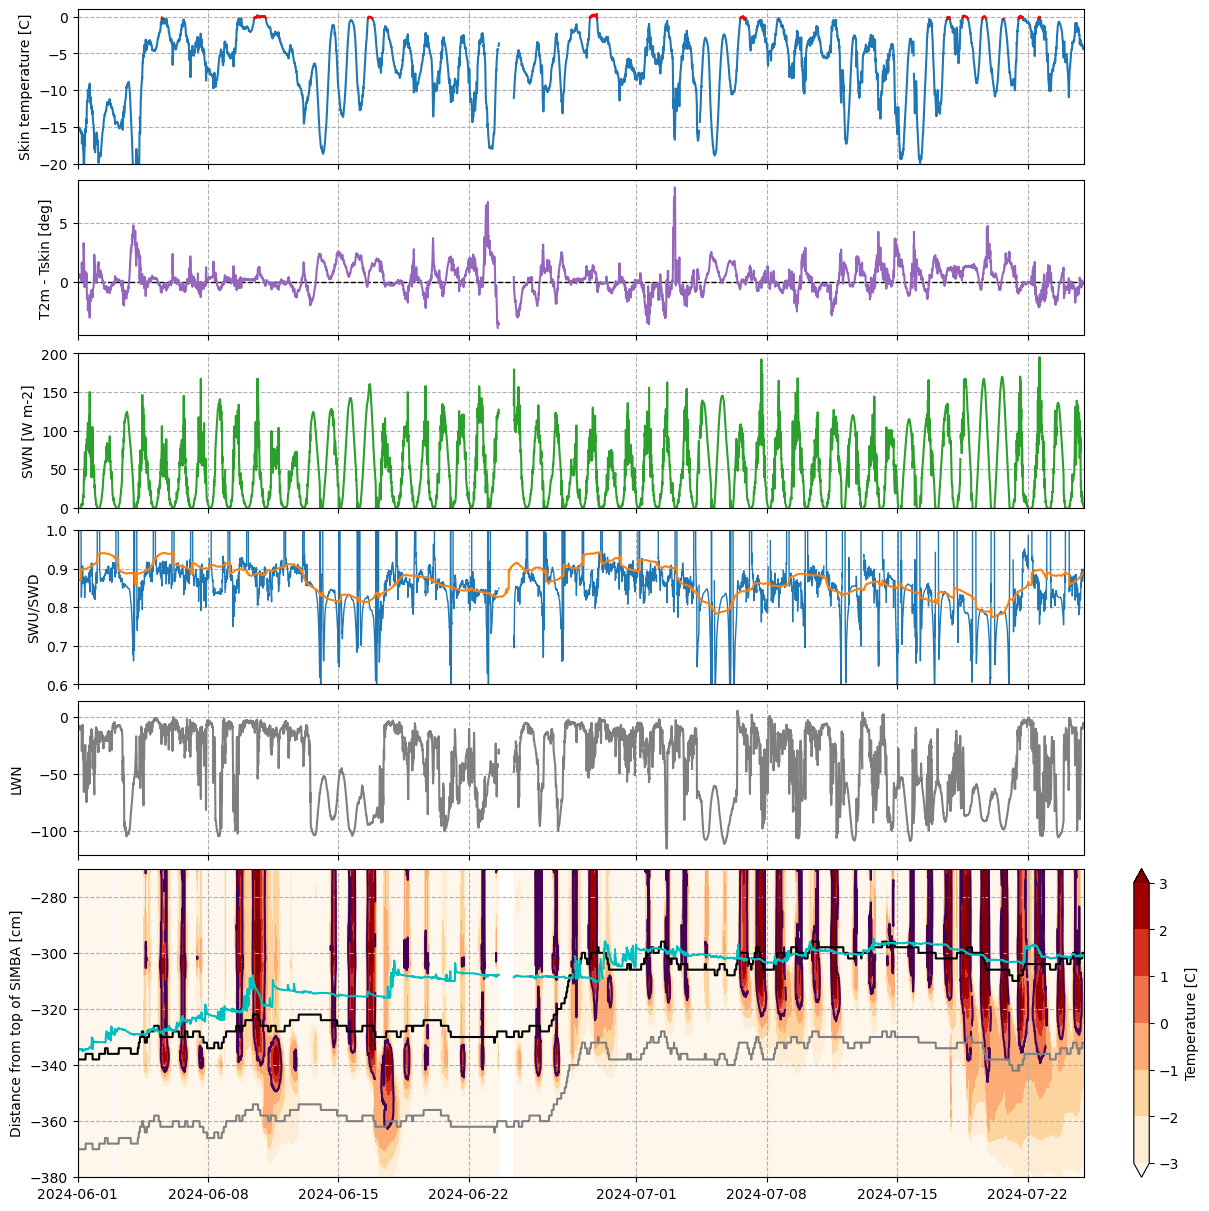

In [64]:
fig, axs = plt.subplots(6, figsize=(12,12), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,1,1,1,1,2]))


cb = axs[-1].contourf(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                cmap=plt.cm.OrRd, levels=np.arange(-3,4,1), extend='both')
plt.colorbar(cb, ax=axs[-1], label='Temperature [C]')
cb = axs[-1].contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                levels=[0], extend='both', lw=1)
axs[-1].set_ylabel('Distance from top of SIMBA [cm]')

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.32), c='r')
axs[0].set_ylabel('Skin temperature [C]')

axs[1].axhline(y=0, c='k', ls='--', lw=1)
axs[1].plot(asfs_data_lev2['dates'], asfs_data_lev2['temp']-(sleigh_tskin_all-273.15), c='tab:purple')
axs[1].set_ylabel('T2m - Tskin [deg]')

axs[2].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_short_hemisp']-asfs_data_lev2['up_short_hemisp'], c='tab:green')
axs[2].set_ylabel('SWN [W m-2]')


axs[3].plot(asfs_data_lev2['dates'], albedo, lw=1)
axs[3].plot(asfs_data_lev2['dates'], albedo_smoothed,)

axs[3].set_ylabel('SWU/SWD')
axs[3].set_ylim(0.6,1)

# axs[0].set_xlim(datetime.datetime(2024,7,18),datetime.datetime(2024,7,25))
axs[0].set_ylim(-20,1)
axs[1].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))


axs[4].plot(asfs_data_lev2['dates'], asfs_data_lev2['down_long_hemisp']-asfs_data_lev2['up_long_hemisp'], c='tab:gray')
axs[4].set_ylabel('LWN')


axs[-1].plot(plt_times, 100.*rnd_sfc-32, color='gray')
axs[-1].plot(plt_times, 100*rnd_sfc, c='k')
ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='c')

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[2].set_ylim(0,200)
axs[-1].set_ylim(-380, -270)
plt.savefig('/home/asledd/ICECAPS/figures/Raven_skinT_SWN_albedo_LWN_deltaT_temp-contour_20240601-20240725.png', dpi=250)

plt.show()

Thermistor #170 (-340cm) had a ~2cm ice layer at demob.

Current hypothesis: above 0C at depth is combination of some solar penetration bias PLUS latent heat from melt water refreezing?

In [65]:
seconds = np.array([(t-datetime.datetime(1970,1,1)).total_seconds() for t in season_data['dates']])
T_grad = np.gradient(season_data['temperature'], seconds, axis=0)*60.*15.

NameError: name 'T_temp_grad' is not defined

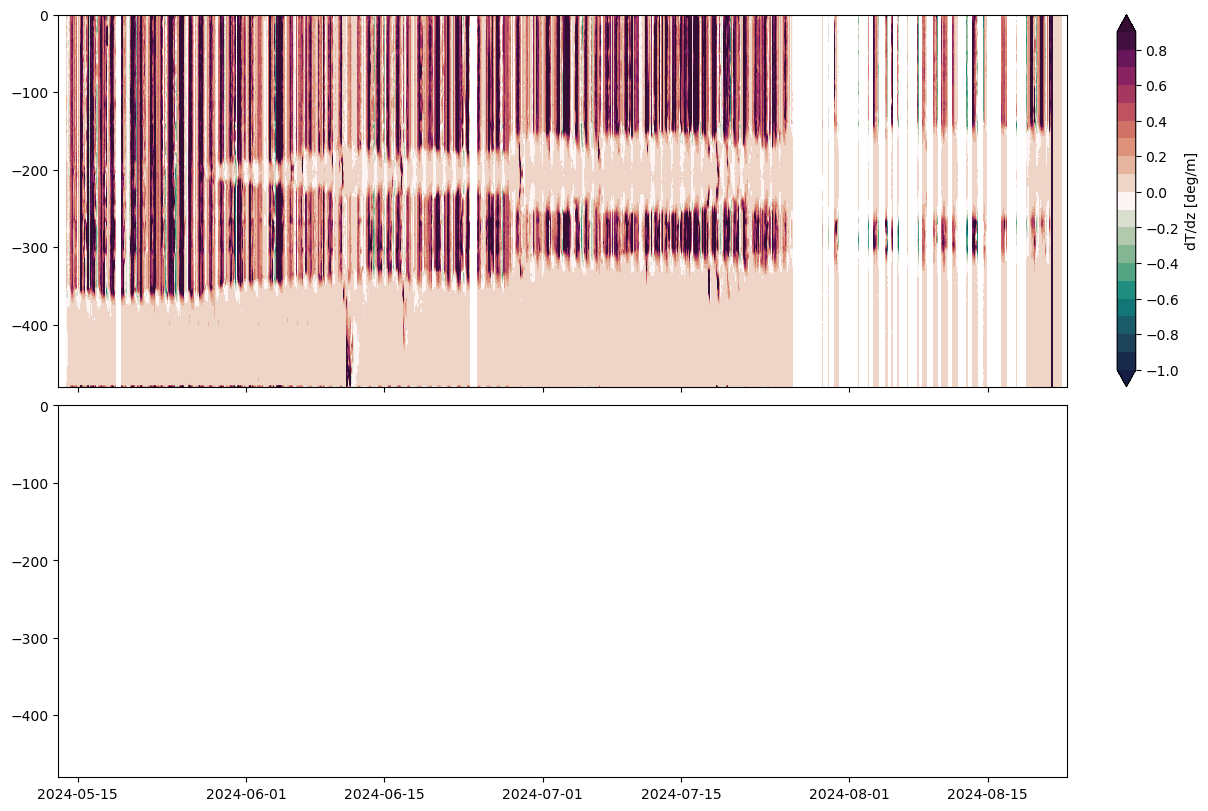

In [66]:
fig, axs = plt.subplots(2, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)

cb = axs[0].contourf(season_data['dates'], season_data['height'], np.swapaxes(T_grad,0,1),
                             cmap=cmocean.cm.curl, levels=np.arange(-1,1,.1), extend='both')
plt.colorbar(cb, label='dT/dz [deg/m]', ax=axs[0])

cb = axs[1].contourf(season_data['dates'], season_data['height'], np.swapaxes(T_temp_grad,0,1),
                             cmap=cmocean.cm.balance, levels=np.arange(-1,1.01,.1), extend='both')
plt.colorbar(cb, label='dT/dt [deg/s]', ax=axs[1])

axs[0].set_xlim(datetime.datetime(2024,6,15),datetime.datetime(2024,7,25))

for ax in axs.ravel():
    ax.plot(plt_times, 100*rnd_sfc, c='r', lw=2)
    ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='c', lw=2)
    ax.grid(ls='--')
    ax.contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
                    levels=[0], extend='both', cmap=plt.cm.spring_r)
    ax.set_ylabel('Distance from top of SIMBA [cm]')

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[0].set_ylim(-400, -300)


plt.show()

Specifically compare melt and surface height changes

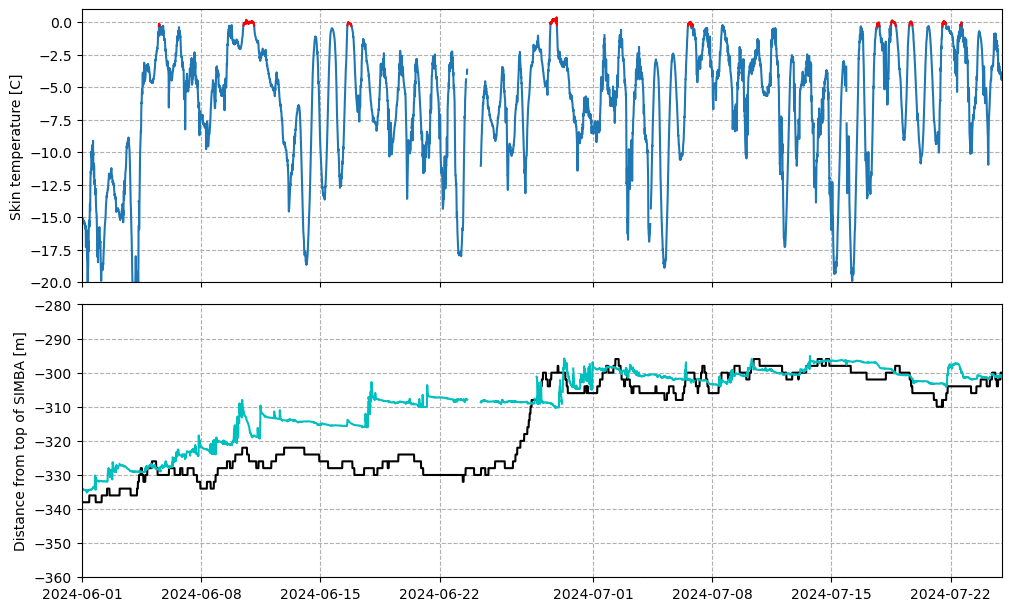

In [72]:
fig, axs = plt.subplots(2, figsize=(10,6), constrained_layout=True, sharex=True, )#gridspec_kw=dict(height_ratios=[1,1,1,2]))


axs[-1].set_ylabel('Distance from top of SIMBA [m]')

# ax.axhline(y=-350, c='r', ls='--') ## initial thermistor at the surface when the instrument was installed
for i, ax in enumerate(axs.ravel()):
    ax.grid(ls='--')

axs[0].plot(asfs_data_lev2['dates'], sleigh_tskin_all-273.15)
axs[0].plot(asfs_data_lev2['dates'], np.ma.masked_less(sleigh_tskin_all-273.15, -0.3), c='r')
axs[0].set_ylabel('Skin temperature [C]')

axs[0].set_xlim(datetime.datetime(2024,6,1),datetime.datetime(2024,7,25))
axs[0].set_ylim(-20,1)

axs[-1].plot(plt_times, 100*rnd_sfc, c='k')
ax.plot(asfs_data_lev2['dates'], asfs_data_lev2['snow_depth']-350, c='c')

# axs[1].set_xlim(plt_times_not_smooth[0], plt_times_not_smooth[-1])
axs[1].set_ylim(0,200)
axs[-1].set_ylim(-360, -280)
# plt.savefig('/home/asledd/ICECAPS/keff_retrieval/Raven_dtdz-flux-profile-timeseries_skinT_3level-smoothing-window.png', dpi=250)

plt.show()

### Looking at profiles for temperature, dT/dz and dT/dt for different times/conditions

In [73]:
subsurface_dTdz = np.ma.masked_outside(np.ma.masked_where(depth_repeat>sfc_repeat, smoothed_dTdz[:,dTdz_depth_idx[:-1]][date_idx_imb,:]), -900,900)
subsurface_dTdt = np.ma.masked_outside(np.ma.masked_where(depth_repeat>sfc_repeat, smoothed_dTdt[:,dTdz_depth_idx[:-1]][date_idx_imb,:]), -900,900)
subsurface_T = np.ma.masked_outside(np.ma.masked_where(depth_repeat>sfc_repeat, smoothed_temp[:,dTdz_depth_idx[:-1]][date_idx_imb,:]), -900,900)

In [74]:
print(subsurface_T.shape, np.shape(plt_times))

(5279, 59) (5279,)


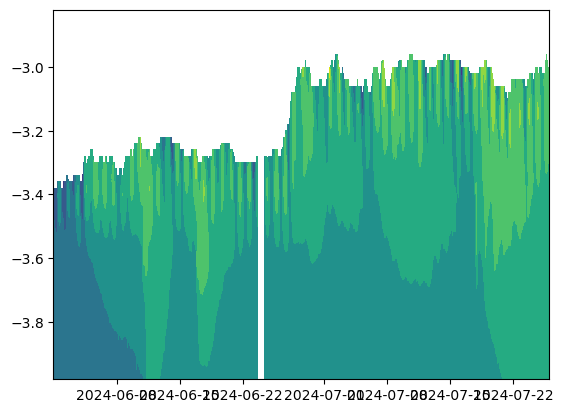

In [75]:
plt.contourf(plt_times, imb_depth_m[padded_depth_idx][:-1], np.swapaxes(subsurface_T,0,1))
plt.show()

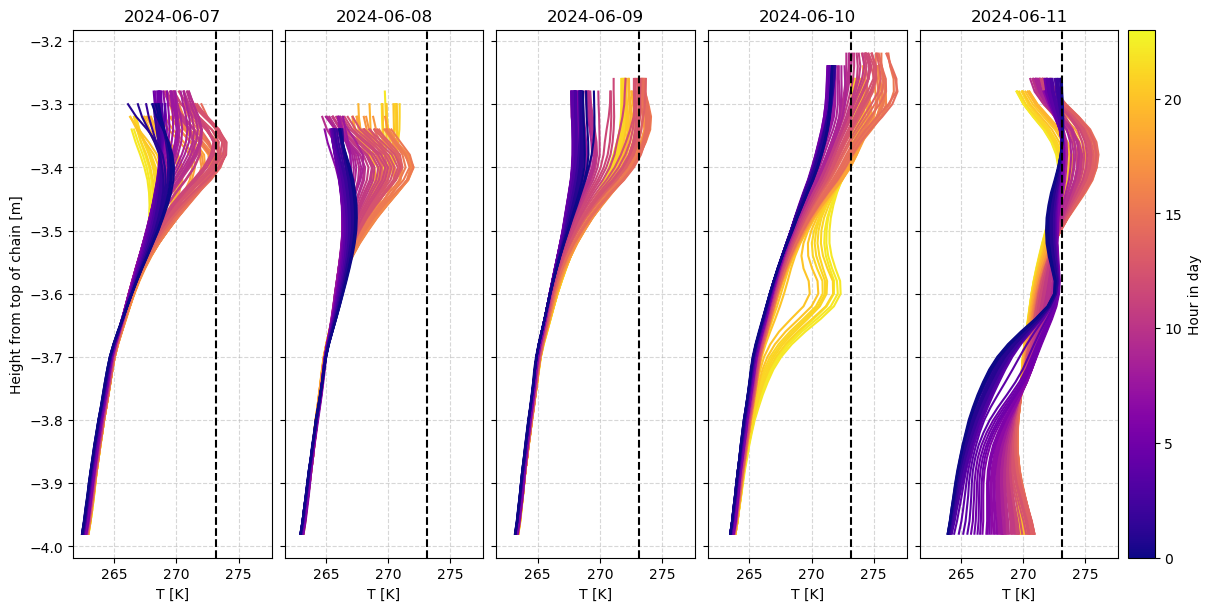

In [79]:


fig, axs = plt.subplots(1,5, figsize=(12,6), sharey=True, sharex=True, constrained_layout=True)
axs[0].set_ylabel('Height from top of chain [m]')

profile_plotting_depth = imb_depth_m[padded_depth_idx][:-1]

n=0
dpth_idx = np.where(profile_plotting_depth==-3.6)[0]

for day, ax in zip(range(7,12), axs.ravel()):
    st_date = datetime.datetime(2024,6,day)
    en_date = datetime.datetime(2024,6,day+1)
    figure_date_idx = np.where((np.asarray(plt_times)>=st_date )&(np.asarray(plt_times)<en_date ))[0]
    
    # cbar_ticks = [plt_times[figure_date_idx[idx]] for idx in [0, int(len(figure_date_idx)/2), len(figure_date_idx)-1]]
    cbar_ticks = [0, 12, 23]
    
    for i, t_idx in np.ndenumerate(figure_date_idx[1:][::-1]):
        
        # col = plt.cm.viridis(i[0]/len(figure_date_idx))
        # print(plt_times[t_idx].hour)
        col = plt.cm.plasma(plt_times[t_idx].hour/24.)

        ax.plot(np.squeeze(subsurface_T[t_idx, :]), profile_plotting_depth, label=t_idx, c=col)#'t=0')
        # if day==10:
        #     print(subsurface_T[t_idx, :][dpth_idx], plt_times[t_idx].hour)
        #     if subsurface_T[t_idx, :][dpth_idx]>269>
            

        # axs[0].plot(np.squeeze(subsurface_T[t_idx, :]), profile_plotting_depth, label=t_idx, c=col)#'t=0')
        # axs[1].plot(np.squeeze(subsurface_dTdt[t_idx, :]), profile_plotting_depth, c=col)
        # axs[2].plot(np.squeeze(subsurface_dTdz[t_idx, :]), profile_plotting_depth, c=col)
        # axs[3].plot(K, imb_depth_m[depth_idx][:-1])

    ax.set_xlabel('T [K]')
    ax.grid(alpha=.5, ls='--')
    ax.set_title(st_date.strftime('%Y-%m-%d'))
    ax.axvline(x=273.15, c='k', ls='--')
# for ax, label in zip(axs.ravel(), ['T [K]', '$T_t-T_{t-1}$ [K]', '$T_z-T_{z-1}$ [K]','k']):
#     ax.set_xlabel(label)
#     ax.grid(alpha=.5, ls='--')

cmappable = ScalarMappable(norm=Normalize(0,23), cmap=plt.cm.plasma)

#colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
cbar = plt.colorbar(cmappable, label='Hour in day')# ticks=np.arange(0, 23))# label='Change in user population')
# cbar.ax.set_yticklabels(cbar_ticks)

# axs[-1].set_xlim(-.1,2)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'--'+en_date.strftime('%m-%d %H:%M'))
#plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d:%H:%M')+'-'+en_date.strftime('%H:%M')+'.png', dpi=200)
plt.show()

96
96
96
96
96


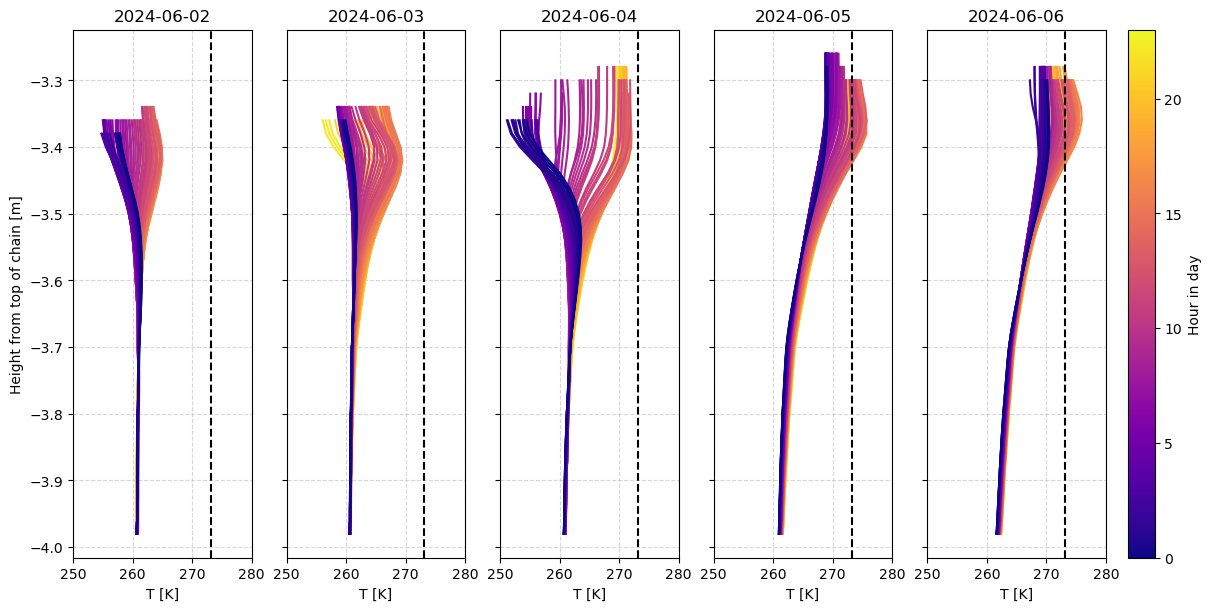

96
96
96
96
96


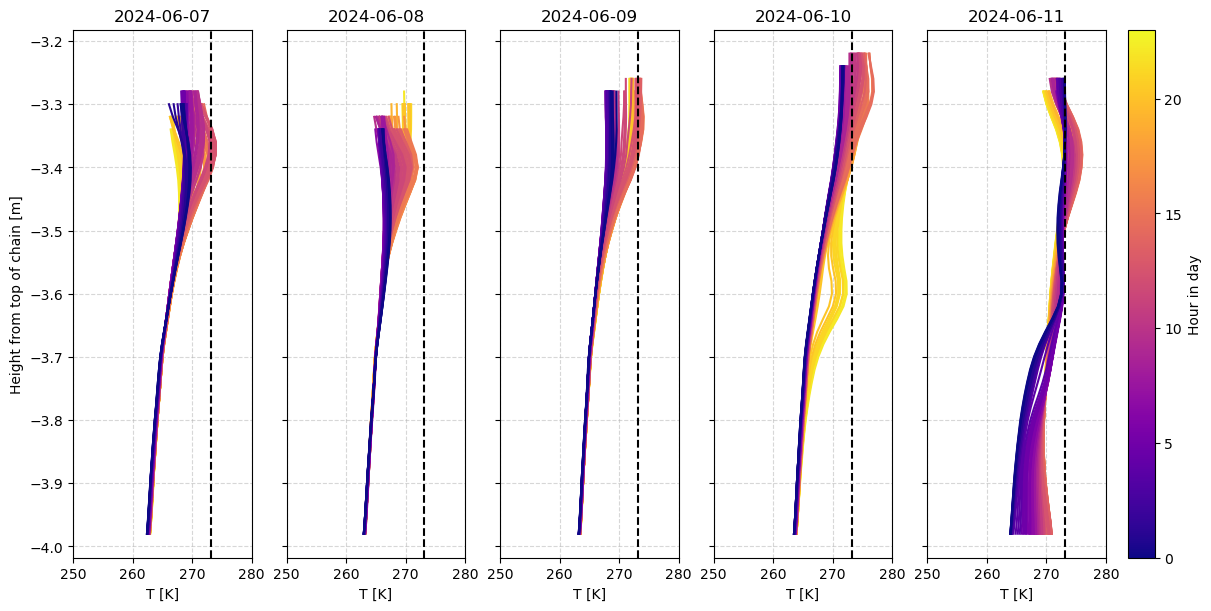

96
96
96
96
96


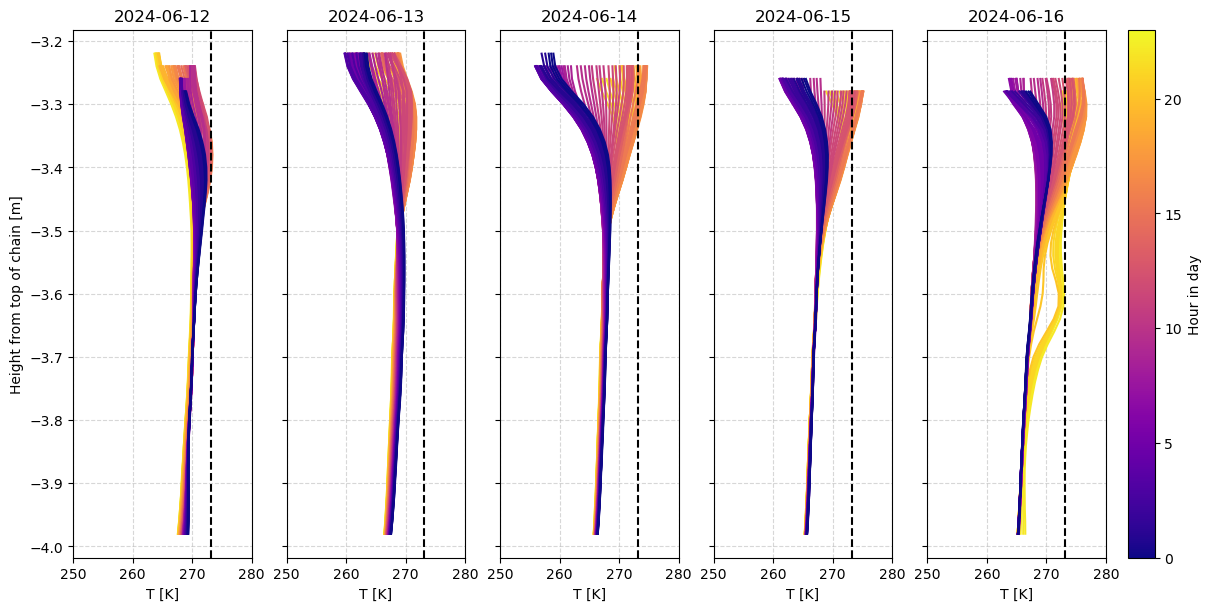

96
96
96
96
96


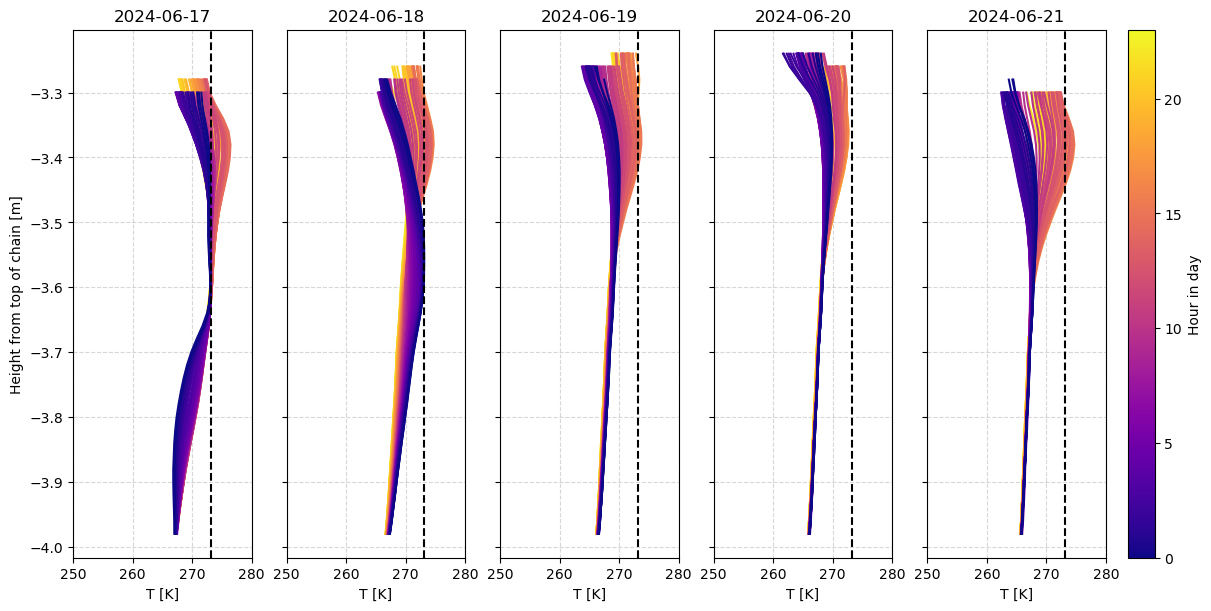

96
96
96
96
96


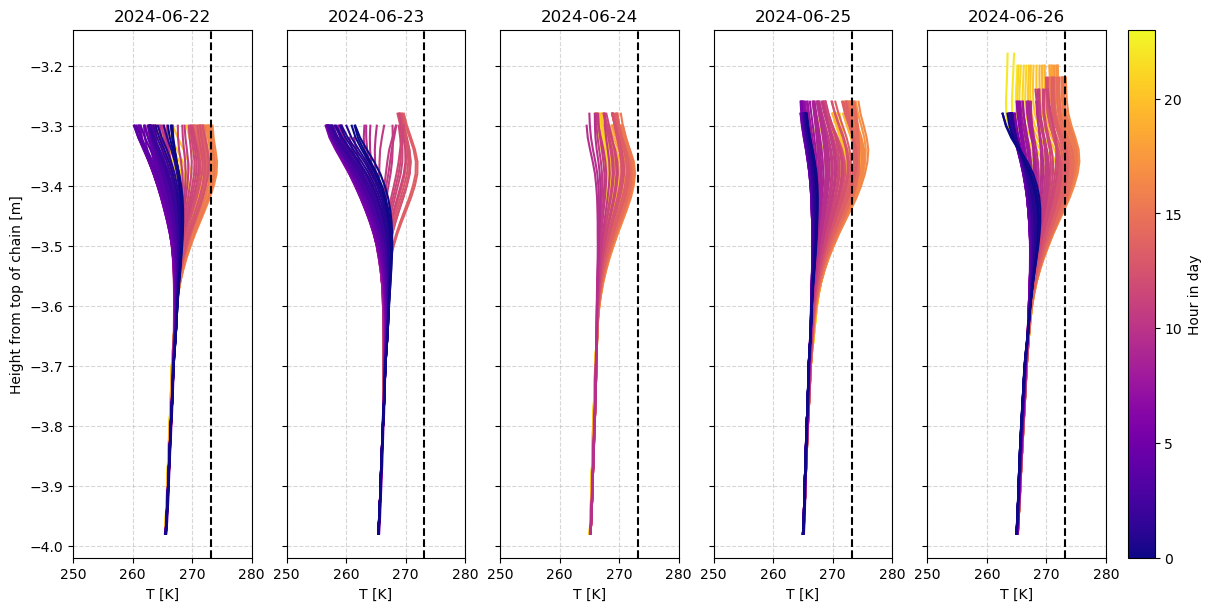

96
96
96
96
96


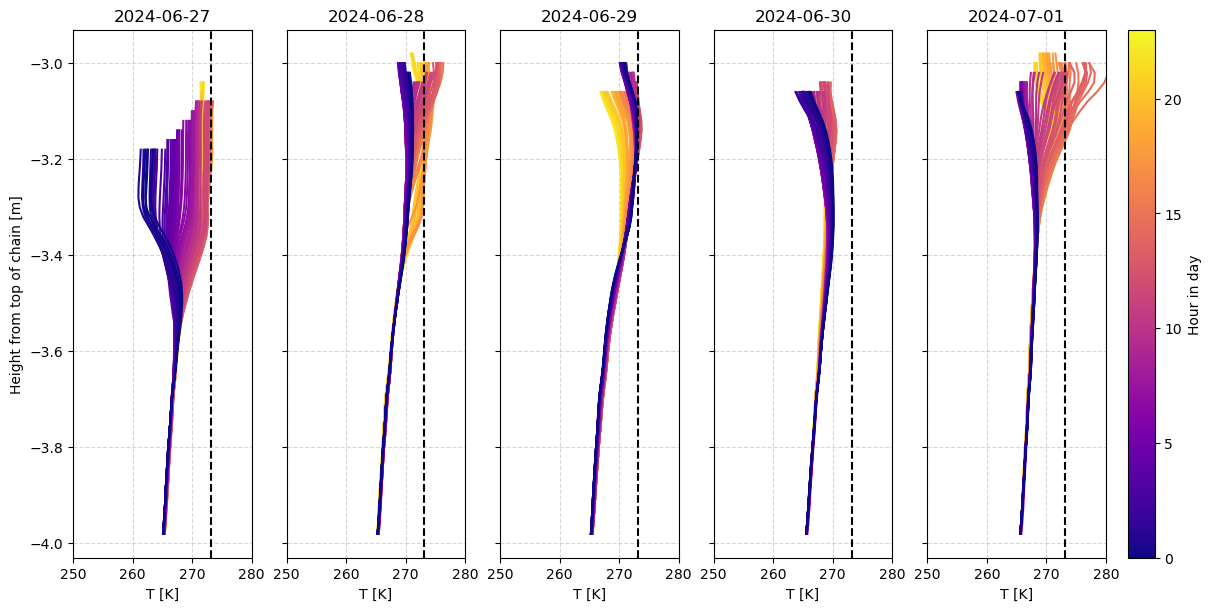

In [81]:

## for june
for day in range(1,31,5):

## for july
# for day in range(1,26,5):
    fig, axs = plt.subplots(1,5, figsize=(12,6), sharey=True, sharex=True, constrained_layout=True)
    axs[0].set_ylabel('Height from top of chain [m]')
    
    profile_plotting_depth = imb_depth_m[padded_depth_idx][:-1]
    
    # day = 9
    for ad, ax in zip(range(5), axs.ravel()):
        st_date = datetime.datetime(2024,6,1)+datetime.timedelta(days=day+ad)
        en_date = st_date+datetime.timedelta(days=1)
        figure_date_idx = np.where((np.asarray(plt_times)>=st_date )&(np.asarray(plt_times)<en_date ))[0]
        print(len(figure_date_idx))
        # cbar_ticks = [plt_times[figure_date_idx[idx]] for idx in [0, int(len(figure_date_idx)/2), len(figure_date_idx)-1]]
        cbar_ticks = [0, 12, 23]
        
        for i, t_idx in np.ndenumerate(figure_date_idx[1:][::-1]):
            
            col = plt.cm.plasma(plt_times[t_idx].hour/24.)
    
            ax.plot(np.squeeze(subsurface_T[t_idx, :]), profile_plotting_depth, label=t_idx, c=col)#'t=0')
    
        ax.set_xlabel('T [K]')
        ax.grid(alpha=.5, ls='--')
        ax.set_title(st_date.strftime('%Y-%m-%d'))
        ax.axvline(x=273.15, c='k', ls='--')
        ax.set_xlim(250, 280)
    cmappable = ScalarMappable(norm=Normalize(0,23), cmap=plt.cm.plasma)
    
    #colorbar from https://stackoverflow.com/questions/65618997/python-matplotlib-custom-colorbar-for-plotted-lines-with-manually-assigned-color
    cbar = plt.colorbar(cmappable, label='Hour in day')# ticks=np.arange(0, 23))#
    # cbar.ax.set_yticklabels(cbar_ticks)
    
    # axs[-1].set_xlim(-.1,2)
    # axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'--'+en_date.strftime('%m-%d %H:%M'))
    daystring_st = datetime.datetime(2024,6,day)
    daystring_en = datetime.datetime(2024,6,day+4)
    filename = 'Raven_temp-height_reverse_'+daystring_st.strftime('%Y%m%d-')+daystring_en.strftime('%Y%m%d')+'.png'
    plt.savefig('/home/asledd/ICECAPS/temperature_profiles/'+filename, dpi=250)
    plt.show()

### Exploring potential calculation for energy of refreezing

Based on 'Quantifying meltwater refreezing on the Greenland ice sheet' by Cox et al. (2015)

In [ ]:
# cb = axs[-1].contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
#                 levels=[0], extend='both', lw=1)

fig, ax = plt.subplots(1, figsize=(3,6))#, sharey=True, constrained_layout=True)
ax.set_ylabel('Height from top of chain [m]')


st_date = datetime.datetime(2024,6,1)
en_date = datetime.datetime(2024,7,26)

for prof_date in [st_date, en_date]:
    st_date_idx = np.where((season_data['dates']>=prof_date )&(season_data['dates']<prof_date+datetime.timedelta(days=1 )))[0]
    ax.plot( season_data['temperature'][st_date_idx, :-1].mean(axis=0), season_data['height'][:-1], label=prof_date.strftime('%Y-%m-%d'))#'t=0')

ax.axhline(y=-340, c='gray')
ax.axhline(y=-370, c='k')

ax.set_ylim(-480,-300)
ax.set_xlabel('T [K]')
ax.grid(alpha=.5, ls='--')

ax.legend(loc='best')

# axs[-1].set_xlim(-.1,2)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'--'+en_date.strftime('%m-%d %H:%M'))
#plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d:%H:%M')+'-'+en_date.strftime('%H:%M')+'.png', dpi=200)
plt.show()

In [ ]:
import scipy

In [ ]:
print(help(scipy.integrate.simpson))

In [ ]:
print(help(scipy.integrate.trapezoid))

First need profiles of density. Then calculate themal conductivity. Then calculate qnet and delta H. Difference to get refreezing.

qnet:
need dT/dz at a given level; need thermal conductivity

In [ ]:
## just start w/ idealized density profile because it's a bit of work to get that

In [ ]:
rho_min = 300.
rho_max = 400.

cp = 2097.#/1000. # heat capacity converted to J/g/degree

In [ ]:
T_grad = np.gradient(season_data['temperature'], season_data['height']/100., axis=1)

In [ ]:
cb = plt.contourf(season_data['dates'], season_data['height'], np.swapaxes(T_grad,0,1),
                             cmap=cmocean.cm.curl, levels=np.arange(-10,10,1), extend='both')
plt.colorbar(cb, label='dT/dz [deg/m]')
plt.show()

In [ ]:
## levels are 30cm below initial surface on June 1, 2024 (-340) -> -370cm
## bottom is -478 cm -> 138 depth
lf_depth_idx = np.where( (season_data['height']<=-370)&(season_data['height']>=-476) )[0]

In [ ]:
_, k_profile_300 = calc_k_approx(season_data['temperature'][:,lf_depth_idx]+273.15, 300.)
_, k_profile_400 = calc_k_approx(season_data['temperature'][:,lf_depth_idx]+273.15, 400.)

In [ ]:
print(calc_k_approx(-3.+273.15, 888))

In [ ]:
# cb = axs[-1].contour(season_data['dates'], season_data['height'], np.swapaxes(season_data['temperature'],0,1),
#                 levels=[0], extend='both', lw=1)

fig, axs = plt.subplots(1, 2, figsize=(6,6), sharey=True, constrained_layout=True)
axs[0].set_ylabel('Height from top of chain [m]')


st_date = datetime.datetime(2024,6,1)
en_date = datetime.datetime(2024,7,26)

for prof_date in [st_date, en_date]:
    st_date_idx = np.where((season_data['dates']>=prof_date )&(season_data['dates']<prof_date+datetime.timedelta(days=1 )))[0]
    axs[0].plot( season_data['temperature'][st_date_idx, :-1].mean(axis=0), season_data['height'][:-1], 
                label=prof_date.strftime('%Y-%m-%d'))#'t=0')

    axs[1].plot(k_profile_300[st_date_idx,:].mean(axis=0), season_data['height'][lf_depth_idx], label=prof_date.strftime('%Y-%m-%d'))

for ax, label in zip(axs.ravel(),['T [K]', 'keff [W m-1 K-1]']):
    ax.axhline(y=-340, c='gray')
    ax.axhline(y=-380, c='k')
    
    ax.set_ylim(-480,-300)
    ax.set_xlabel(label)
    ax.grid(alpha=.5, ls='--')

axs[1].legend(loc='best')

# axs[-1].set_xlim(-.1,2)
# axs[1].set_title(st_date.strftime('%Y-%m-%d %H:%M')+'--'+en_date.strftime('%m-%d %H:%M'))
#plt.savefig('raven_T_Tt_Tz_deltas_'+st_date.strftime('%Y-%m-%d:%H:%M')+'-'+en_date.strftime('%H:%M')+'.png', dpi=200)
plt.show()

In [ ]:
st_date = datetime.datetime(2024,6,1)
st_date_idx = np.where((season_data['dates']>=st_date )&(season_data['dates']<st_date+datetime.timedelta(days=1 )))[0]
en_date = datetime.datetime(2024,7,26)
en_date_idx = np.where((season_data['dates']>=en_date )&(season_data['dates']<en_date+datetime.timedelta(days=1 )))[0]

initial_temp = season_data['temperature'][st_date_idx, :].mean(axis=0)[lf_depth_idx]
final_temp = season_data['temperature'][en_date_idx, :].mean(axis=0)[lf_depth_idx]
delta_H = scipy.integrate.simpson( (final_temp - initial_temp)*rho_min*cp, dx=0.02)
print(delta_H)

In [ ]:
FC = -k_profile_300*T_grad[:,lf_depth_idx]

In [ ]:
qnet = FC[:,np.where(season_data['height'][lf_depth_idx]==-370)[0]] - FC[:,np.where(season_data['height'][lf_depth_idx]==-476)[0]]
plt.plot(season_data['dates'], qnet)
plt.show()

In [ ]:
season_idx = np.where((season_data['dates']>=st_date )&(season_data['dates']<en_date+datetime.timedelta(days=1 )))[0]
qnet[qnet.mask] = 0
Q = scipy.integrate.trapezoid(np.squeeze(qnet[season_idx]), seconds[season_idx])

In [ ]:
plt.plot(season_data['dates'][season_idx], FC[:,np.where(season_data['height'][lf_depth_idx]==-380)[0]][season_idx], label='top')
plt.plot(season_data['dates'][season_idx], FC[:,np.where(season_data['height'][lf_depth_idx]==-476)[0]][season_idx], label='bottom')
plt.legend(loc='best')
plt.ylim(-5,5)
plt.show()

In [ ]:
print(Q)

In [ ]:
print(delta_H, Q, delta_H+Q)